In [1]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
from functools import reduce
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

In [2]:
pd.options.display.max_columns = 150
pd.options.display.max_rows = 100

# 1. Data Description

## Social & Economic

**SE_Unemploy:** Unemployment rate
    
**SE_Income:** Median household incomes(dollars)

**SE_Cash:** Percent households receiving cash public assistance

**SE_Food:** Percent households receiving Food Stamps/Supplemental Nutrition Assistance Program

**SE_Insurance:** Percent individuals with health insurance coverage

**SE_Poverty:** Percent individuals ages 18 years and over with incomes below the federal poverty level in the past 12 months

**SE_English:** Percent citizens 18 years old and over speak English less than very well
    
## Education(E)

**E_Advance:** Population 25 years and over who has Bachelor's degree or higher

**E_PreS:** Population 3 to 4 years olds enrolled in school

**E_HighS:** Population 15 to 17 year olds enrolled in school

## Natural Environment (NE)
**NE_Tem:** Typical summer day surface temperature

**NE_PM25:** PM2.5 levels in air, µg/m3 annual avg.

**NE_Ozone:** Ozone summer seasonal avg. of daily maximum 8-hour concentration in air in parts per billion

## Built Environment (BE)
**BE_TreeD:** Trees density (trees/acre/people)(weighted by population)

**BE_LandMIX:** Land-Use mix of commercial, residential (Employment and household entropy)

**BE_nodeD:** Intersection density in terms of pedestrian-oriented intersections.(number of intersection/acre/people)(weighted by population)

**BE_HFood:** Numbers of supermarkets within 15 min walk distance (0.8 mile) (weighted by population)

**BE_WalkVSDrive:** The area of sidewalks divided by the sum of the area of the roadway segment and the area sidewalks in a given census tract (weighted by population)

**BE_Transit:** Numbers of Transits(train, subway, bus, or ferry stop.) within 15 min walk distance (0.8 mile) (weighted by population)

**BE_Park:** Area(arce) of parks within 15 min walk distance (0.8 mile) (weighted by population)

In [3]:
Health_Status = pd.read_csv('./Data/Processed_Data/Domain/Health_Status.csv', index_col=0)
Health_Status = Health_Status[['MHLTH','PHLTH']]
Health_Status.head()

MHLTH  PHLTH
36005000100   19.3   14.0
36005000200   13.9   13.4
36005000400   12.4   10.8
36005001600   16.0   16.8
36005001900   16.6   13.9

In [4]:
# reversed less than health data to represent healthy level
Health_Status['MH'] = 100-Health_Status['MHLTH']
Health_Status['PH'] = 100-Health_Status['PHLTH']
Health_Status = Health_Status[['MH','PH']]
Health_Status.head()

MH    PH
36005000100  80.7  86.0
36005000200  86.1  86.6
36005000400  87.6  89.2
36005001600  84.0  83.2
36005001900  83.4  86.1

In [92]:
BE = pd.read_csv('./Data/Processed_Data/Domain/Built_Environment.csv', index_col=0).set_index('GeoID')
E = pd.read_csv('./Data/Processed_Data/Domain/Education.csv').set_index('GeoID')
NE = pd.read_csv('./Data/Processed_Data/Domain/Environment.csv').set_index('GeoID')
SE = pd.read_csv('./Data/Processed_Data/Domain/Social_Economic.csv').set_index('GeoID')

In [93]:
# merge data
dfs = [BE, E, NE, SE, Health_Status]
data  = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), dfs)
data.head()

BE_TreeD  BE_HFood   BE_Park  BE_LandUseMix  BE_WalkVSDrive  \
36005000200  0.001039  0.000000  0.027208       0.160274        0.000062   
36005000400  0.000862  0.000000  0.014828       0.392961        0.000054   
36005001600  0.000784  0.000177  0.025224       0.442828        0.000058   
36005001900  0.000745  0.000578  0.078188       0.461624        0.000171   
36005002000  0.000580  0.000121  0.023708       0.274914        0.000049   

             BE_nodeD  BE_Transit  BE_BikeD  E_Advance  E_PreS  E_HighS  \
36005000200  0.298228    0.001033  0.004839       29.4    29.9    100.0   
36005000400  0.246001    0.000610  0.024866       28.4    53.1    100.0   
36005001600  0.452951    0.001719  0.012343       18.5    76.6     90.6   
36005001900  0.436530    0.010265  0.030020       24.6    25.3     93.6   
36005002000  0.269837    0.001279  0.003655        8.4    87.5    100.0   

                NE_Tem   NE_Ozone   NE_PM25  SE_Unemploy  SE_Income  SE_Cash  \
36005000200  94.643103  42.521795  8.939136         13.5    51100.0      8.3   
36005000400  92.135510  42.587127  8.902753          6.2    78409.0      7.1   
36005001600  96.693606  42.587327  8.949253          4.8    34093.0      7.7   
36005001900  96.796323  42.051273  9.157725         10.7    45156.0      7.7   
36005002000  93.799532  42.509834  8.983487         18.9    20592.0     11.7   

             SE_Food  SE_Insurance  SE_Poverty  SE_English    MH    PH  
36005000200     21.5          93.3        23.0        15.4  86.1  86.6  
36005000400      8.4          94.9         7.7        10.8  87.6  89.2  
36005001600     35.3          93.6        25.3        17.3  84.0  83.2  
36005001900     31.6          85.2        30.4        11.1  83.4  86.1  
36005002000     52.6          91.0        42.4        13.3  79.5  78.6

## Data Descriptive analysis

In [94]:
data.describe()

BE_TreeD     BE_HFood      BE_Park  BE_LandUseMix  BE_WalkVSDrive  \
count  2003.000000  2003.000000  2003.000000    2003.000000     2003.000000   
mean      0.001792     0.001944     0.028818       0.439914        0.000117   
std       0.001137     0.002308     0.035747       0.161605        0.000060   
min       0.000000     0.000000     0.000248       0.018581        0.000014   
25%       0.001029     0.000549     0.006238       0.328240        0.000073   
50%       0.001537     0.001252     0.015257       0.432074        0.000102   
75%       0.002261     0.002536     0.036643       0.545409        0.000146   
max       0.011918     0.029856     0.290152       0.960401        0.000435   

          BE_nodeD   BE_Transit     BE_BikeD    E_Advance       E_PreS  \
count  2003.000000  2003.000000  2003.000000  2003.000000  2003.000000   
mean      0.452487     0.008729     0.021448    35.136845    62.971393   
std       0.388956     0.010395     0.030248    20.239924    28.817686   
min       0.000000     0.000000     0.000000     2.400000     0.000000   
25%       0.218358     0.003205     0.000000    20.500000    42.900000   
50%       0.342280     0.006002     0.012290    30.300000    65.100000   
75%       0.563510     0.010542     0.030141    44.550000    87.150000   
max       4.957380     0.178915     0.460928    97.000000   100.000000   

           E_HighS       NE_Tem     NE_Ozone      NE_PM25  SE_Unemploy  \
count  2003.000000  2003.000000  2003.000000  2003.000000  2003.000000   
mean     97.282876    94.608211    42.035108     8.842942     6.501697   
std       7.193782     2.192793     0.540249     0.312602     4.274731   
min      36.400000    83.718909    41.415744     7.797531     0.000000   
25%     100.000000    93.266750    41.539736     8.635181     3.600000   
50%     100.000000    94.837580    41.876424     8.892654     5.500000   
75%     100.000000    96.179671    42.487053     9.100888     8.200000   
max     100.000000   100.162658    43.600054     9.297862    39.100000   

           SE_Income      SE_Cash      SE_Food  SE_Insurance   SE_Poverty  \
count    2003.000000  2003.000000  2003.000000   2003.000000  2003.000000   
mean    70260.149775     4.508487    19.572092     92.417424    15.826261   
std     34325.815766     4.357176    15.480047      4.995314    10.480142   
min      9740.000000     0.000000     0.000000     58.000000     0.400000   
25%     47289.500000     1.400000     7.400000     90.100000     8.000000   
50%     65698.000000     3.200000    15.100000     93.300000    13.100000   
75%     86051.500000     6.400000    27.800000     96.000000    21.400000   
max    250000.000000    37.300000    78.000000    100.000000    69.800000   

        SE_English           MH           PH  
count  2003.000000  2003.000000  2003.000000  
mean     18.107639    86.091563    87.376635  
std      13.744256     2.856453     3.425393  
min       0.000000    74.900000    74.300000  
25%       6.900000    84.500000    85.600000  
50%      15.500000    86.500000    87.700000  
75%      25.800000    88.000000    89.400000  
max      80.700000    92.200000    95.600000

In [21]:
data.to_csv('./Data/Final_Data/Final_Data.csv')

## Z-Score Data Descriptive analysis

In [95]:
# Z-score transform
scaler=StandardScaler().fit(data)     
X_scale=scaler.transform(data) 
data_Z = pd.DataFrame(X_scale)
data_Z.columns = data.columns
data_Z.head()

BE_TreeD  BE_HFood   BE_Park  BE_LandUseMix  BE_WalkVSDrive  BE_nodeD  \
0 -0.662373 -0.842791 -0.045052      -1.730821       -0.903941 -0.396696   
1 -0.818237 -0.842791 -0.391468      -0.290617       -1.036105 -0.531006   
2 -0.887313 -0.765981 -0.100558       0.018036       -0.970307  0.001192   
3 -0.921100 -0.592375  1.381428       0.134369        0.906876 -0.041036   
4 -1.066606 -0.790389 -0.142972      -1.021263       -1.127281 -0.469709   

   BE_Transit  BE_BikeD  E_Advance    E_PreS   E_HighS    NE_Tem  NE_Ozone  \
0   -0.740547 -0.549264  -0.283513 -1.147894  0.377799  0.015916  0.901082   
1   -0.781240  0.113004  -0.332932 -0.342632  0.377799 -1.127930  1.022041   
2   -0.674569 -0.301096  -0.822187  0.473043 -0.929211  0.951260  1.022411   
3    0.147751  0.283459  -0.520727 -1.307558 -0.512080  0.998114  0.029927   
4   -0.716906 -0.588386  -1.321325  0.851378  0.377799 -0.368881  0.878936   

    NE_PM25  SE_Unemploy  SE_Income   SE_Cash   SE_Food  SE_Insurance  \
0  0.307798     1.637542  -0.558324  0.870394  0.124573      0.176725   
1  0.191383    -0.070595   0.237456  0.594917 -0.721889      0.497105   
2  0.340169    -0.398182  -1.053906  0.732656  1.016265      0.236796   
3  1.007231     0.982366  -0.731532  0.732656  0.777188     -1.445200   
4  0.449710     2.901095  -1.447323  1.650911  2.134112     -0.283822   

   SE_Poverty  SE_English        MH        PH  
0    0.684679   -0.197051  0.002955 -0.226785  
1   -0.775590   -0.531820  0.528212  0.532441  
2    0.904196   -0.058777 -0.732407 -1.219620  
3    1.390952   -0.509987 -0.942510 -0.372790  
4    2.536261   -0.349880 -2.308180 -2.562867

In [96]:
data_Z.describe()

BE_TreeD      BE_HFood       BE_Park  BE_LandUseMix  \
count  2.003000e+03  2.003000e+03  2.003000e+03   2.003000e+03   
mean   8.580256e-17  1.001584e-16 -9.699902e-20  -9.744244e-17   
std    1.000250e+00  1.000250e+00  1.000250e+00   1.000250e+00   
min   -1.576767e+00 -8.427909e-01 -7.994300e-01  -2.607823e+00   
25%   -6.712587e-01 -6.049943e-01 -6.318323e-01  -6.912042e-01   
50%   -2.240173e-01 -3.002026e-01 -3.794621e-01  -4.852676e-02   
75%    4.123965e-01  2.565845e-01  2.189587e-01   6.529565e-01   
max    8.910007e+00  1.209812e+01  7.312495e+00   3.221531e+00   

       BE_WalkVSDrive      BE_nodeD    BE_Transit      BE_BikeD     E_Advance  \
count    2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   
mean     5.875369e-17 -8.502657e-17 -7.687865e-17 -4.163198e-16  1.050915e-16   
std      1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   
min     -1.705593e+00 -1.163629e+00 -8.399752e-01 -7.092679e-01 -1.617843e+00   
25%     -7.271296e-01 -6.020933e-01 -5.316181e-01 -7.092679e-01 -7.233476e-01   
50%     -2.417505e-01 -2.834118e-01 -2.624141e-01 -3.028619e-01 -2.390351e-01   
75%      4.773823e-01  2.855091e-01  1.744087e-01  2.874560e-01  4.651947e-01   
max      5.284428e+00  1.158492e+01  1.637621e+01  1.453305e+01  3.057255e+00   

             E_PreS       E_HighS        NE_Tem      NE_Ozone       NE_PM25  \
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   
mean   3.436537e-18  1.242142e-16 -2.993112e-18  3.583310e-15  2.897665e-15   
std    1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   
min   -2.185710e+00 -8.465377e+00 -4.967190e+00 -1.146729e+00 -3.345059e+00   
25%   -6.966696e-01  3.777989e-01 -6.119116e-01 -9.171630e-01 -6.647826e-01   
50%    7.388305e-02  3.777989e-01  1.046276e-01 -2.937986e-01  1.590663e-01   
75%    8.392292e-01  3.777989e-01  7.168267e-01  8.367584e-01  8.253654e-01   
max    1.285247e+00  3.777989e-01  2.533679e+00  2.897435e+00  1.455635e+00   

        SE_Unemploy     SE_Income       SE_Cash       SE_Food  SE_Insurance  \
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   
mean  -2.239292e-16  3.225910e-17 -9.522532e-16  2.979810e-16  2.169341e-15   
std    1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   
min   -1.521340e+00 -1.763549e+00 -1.034985e+00 -1.264659e+00 -6.891663e+00   
25%   -6.789719e-01 -6.693617e-01 -7.135960e-01 -7.865048e-01 -4.640354e-01   
50%   -2.343885e-01 -1.329404e-01 -3.003813e-01 -2.889661e-01  1.767249e-01   
75%    3.973880e-01  4.601579e-01  4.342228e-01  5.316497e-01  7.173665e-01   
max    7.627718e+00  5.237595e+00  7.527743e+00  3.775344e+00  1.518317e+00   

         SE_Poverty    SE_English            MH            PH  
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  
mean   2.330194e-16 -3.565407e-16 -1.543559e-15  2.153046e-15  
std    1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  
min   -1.472319e+00 -1.317799e+00 -3.918971e+00 -3.818510e+00  
25%   -7.469570e-01 -8.156453e-01 -5.573206e-01 -5.187955e-01  
50%   -2.602008e-01 -1.897731e-01  1.430233e-01  9.442586e-02  
75%    5.319710e-01  5.598180e-01  6.682812e-01  5.908431e-01  
max    5.151382e+00  4.555211e+00  2.139003e+00  2.401306e+00

[4, 0]
[5, 1]
[5, 4]
[6, 1]
[6, 5]
[15, 8]
[16, 14]
[16, 15]
[17, 8]
[17, 14]
[17, 15]
[17, 16]
[19, 14]
[19, 15]
[19, 16]
[19, 17]
[21, 8]
[21, 14]
[21, 15]
[21, 16]
[21, 17]
[21, 19]
[22, 8]
[22, 14]
[22, 15]
[22, 16]
[22, 17]
[22, 19]
[22, 21]


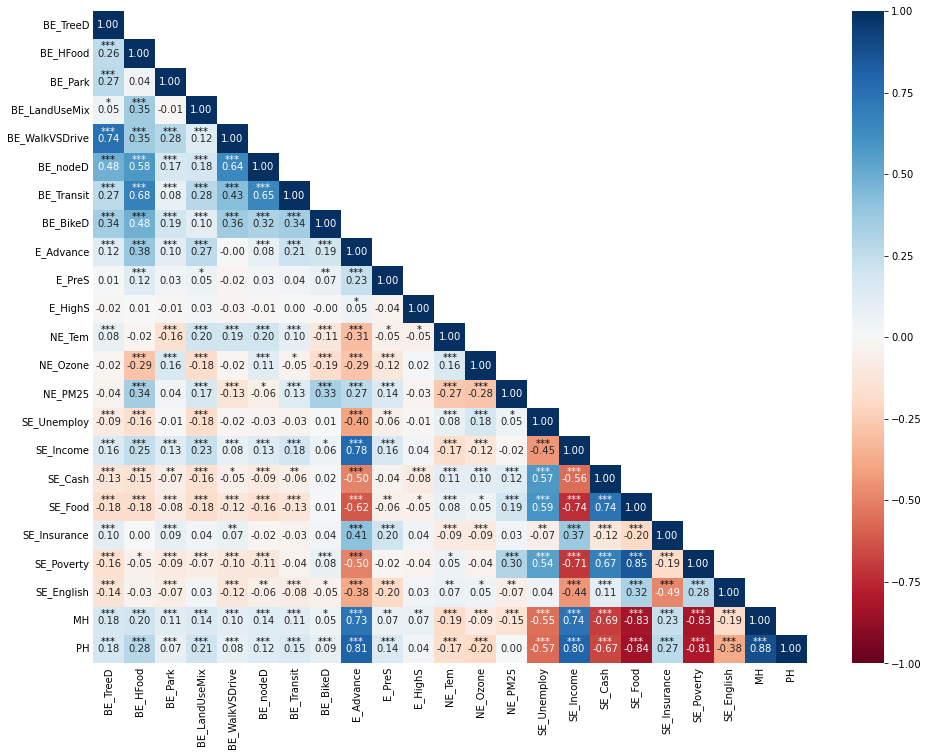

In [97]:
df_coor=data_Z.corr() 
fig = plt.figure(figsize=(16,12))
ax1 = plt.gca()


mask = np.zeros_like(df_coor)
mask[np.triu_indices_from(mask)] = True
mask2 = mask
mask = (np.flipud(mask)-1)*(-1)
mask = np.rot90(mask,k = -1)

im1 = sns.heatmap(df_coor,annot=True,cmap="RdBu"
, mask=mask # triangle format
,vmax=1,vmin=-1
, fmt='.2f',ax = ax1)

ax1.tick_params(axis = 'both', length=0)

# calculate P-value
df = data_Z
rlist = []
plist = []
for i in df.columns.values:
    for j in df.columns.values:
        r,p = pearsonr(df[i],df[j])
        rlist.append(r)
        plist.append(p)

rarr = np.asarray(rlist).reshape(len(df.columns.values),len(df.columns.values))
parr = np.asarray(plist).reshape(len(df.columns.values),len(df.columns.values))
xlist = ax1.get_xticks()
ylist = ax1.get_yticks()

widthx = 0
widthy = -0.15

for m in ax1.get_xticks():
    for n in ax1.get_yticks():
        pv = (parr[int(m),int(n)])
        rv = (rarr[int(m),int(n)])
        if mask2[int(m),int(n)]<1.:
            if abs(rv) > 0.5:
                if  pv< 0.05 and pv>= 0.01:
                    ax1.text(n+widthx,m+widthy,'*',ha = 'center',color = 'white')
                if  pv< 0.01 and pv>= 0.001:
                    ax1.text(n+widthx,m+widthy,'**',ha = 'center',color = 'white')
                if  pv< 0.001:
                    print([int(m),int(n)])
                    ax1.text(n+widthx,m+widthy,'***',ha = 'center',color = 'white')
            else: 
                if  pv< 0.05 and pv>= 0.01:
                    ax1.text(n+widthx,m+widthy,'*',ha = 'center',color = 'k')
                elif  pv< 0.01 and pv>= 0.001:
                    ax1.text(n+widthx,m+widthy,'**',ha = 'center',color = 'k')
                elif  pv< 0.001:
                    ax1.text(n+widthx,m+widthy,'***',ha = 'center',color = 'k')
#plt.savefig(r'Z:\GJ\pearsonr\fig\r_demo.png',dpi=600)
plt.show()

In [25]:
fig.savefig('./Image/Pearson.jpg', dpi=600,bbox_inches='tight')

## Plot Data

In [26]:
# geo data
ct2010 = gpd.read_file('./Data/Processed_Data/ct2010_geoid.geojson')
ct2010.head()

dataGeo = pd.merge(data, ct2010[['GeoID','boro_name','geometry']], left_index=True, right_on='GeoID').set_index('GeoID')
dataGeo =gpd.GeoDataFrame(dataGeo, geometry=dataGeo.geometry, crs=4326).to_crs(2263)
dataGeo.head()

BE_TreeD  BE_nodeD  BE_HFood  BE_WalkVSDrive  BE_Transit  \
GeoID                                                                   
36005000200  0.001039  0.298228  0.000000        0.000062    0.001033   
36005000400  0.000862  0.246001  0.000000        0.000054    0.000610   
36005001600  0.000784  0.452951  0.000177        0.000058    0.001719   
36005001900  0.000745  0.436530  0.000578        0.000171    0.010265   
36005002000  0.000580  0.269837  0.000121        0.000049    0.001279   

              BE_Park  BE_LandUseMix  BE_BikeD  E_Advance  E_PreS  E_HighS  \
GeoID                                                                        
36005000200  0.027208       0.160274  0.004839       29.4    29.9    100.0   
36005000400  0.014828       0.392961  0.024866       28.4    53.1    100.0   
36005001600  0.025224       0.442828  0.012343       18.5    76.6     90.6   
36005001900  0.078188       0.461624  0.030020       24.6    25.3     93.6   
36005002000  0.023708       0.274914  0.003655        8.4    87.5    100.0   

                NE_Tem   NE_Ozone   NE_PM25  SE_Unemploy  SE_Income  SE_Cash  \
GeoID                                                                          
36005000200  94.643103  42.521795  8.939136         13.5    51100.0      8.3   
36005000400  92.135510  42.587127  8.902753          6.2    78409.0      7.1   
36005001600  96.693606  42.587327  8.949253          4.8    34093.0      7.7   
36005001900  96.796323  42.051273  9.157725         10.7    45156.0      7.7   
36005002000  93.799532  42.509834  8.983487         18.9    20592.0     11.7   

             SE_Food  SE_Insurance  SE_Poverty  SE_English    MH    PH  \
GeoID                                                                    
36005000200     21.5          93.3        23.0        15.4  86.1  86.6   
36005000400      8.4          94.9         7.7        10.8  87.6  89.2   
36005001600     35.3          93.6        25.3        17.3  84.0  83.2   
36005001900     31.6          85.2        30.4        11.1  83.4  86.1   
36005002000     52.6          91.0        42.4        13.3  79.5  78.6   

            boro_name                                           geometry  
GeoID                                                                     
36005000200     Bronx  POLYGON ((1023972.528 232680.658, 1023970.431 ...  
36005000400     Bronx  POLYGON ((1026849.274 235548.774, 1026749.976 ...  
36005001600     Bronx  POLYGON ((1024344.112 238946.021, 1024391.333 ...  
36005001900     Bronx  MULTIPOLYGON (((1012821.806 229228.265, 101278...  
36005002000     Bronx  POLYGON ((1022317.859 237780.872, 1022425.769 ...

/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)
/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)


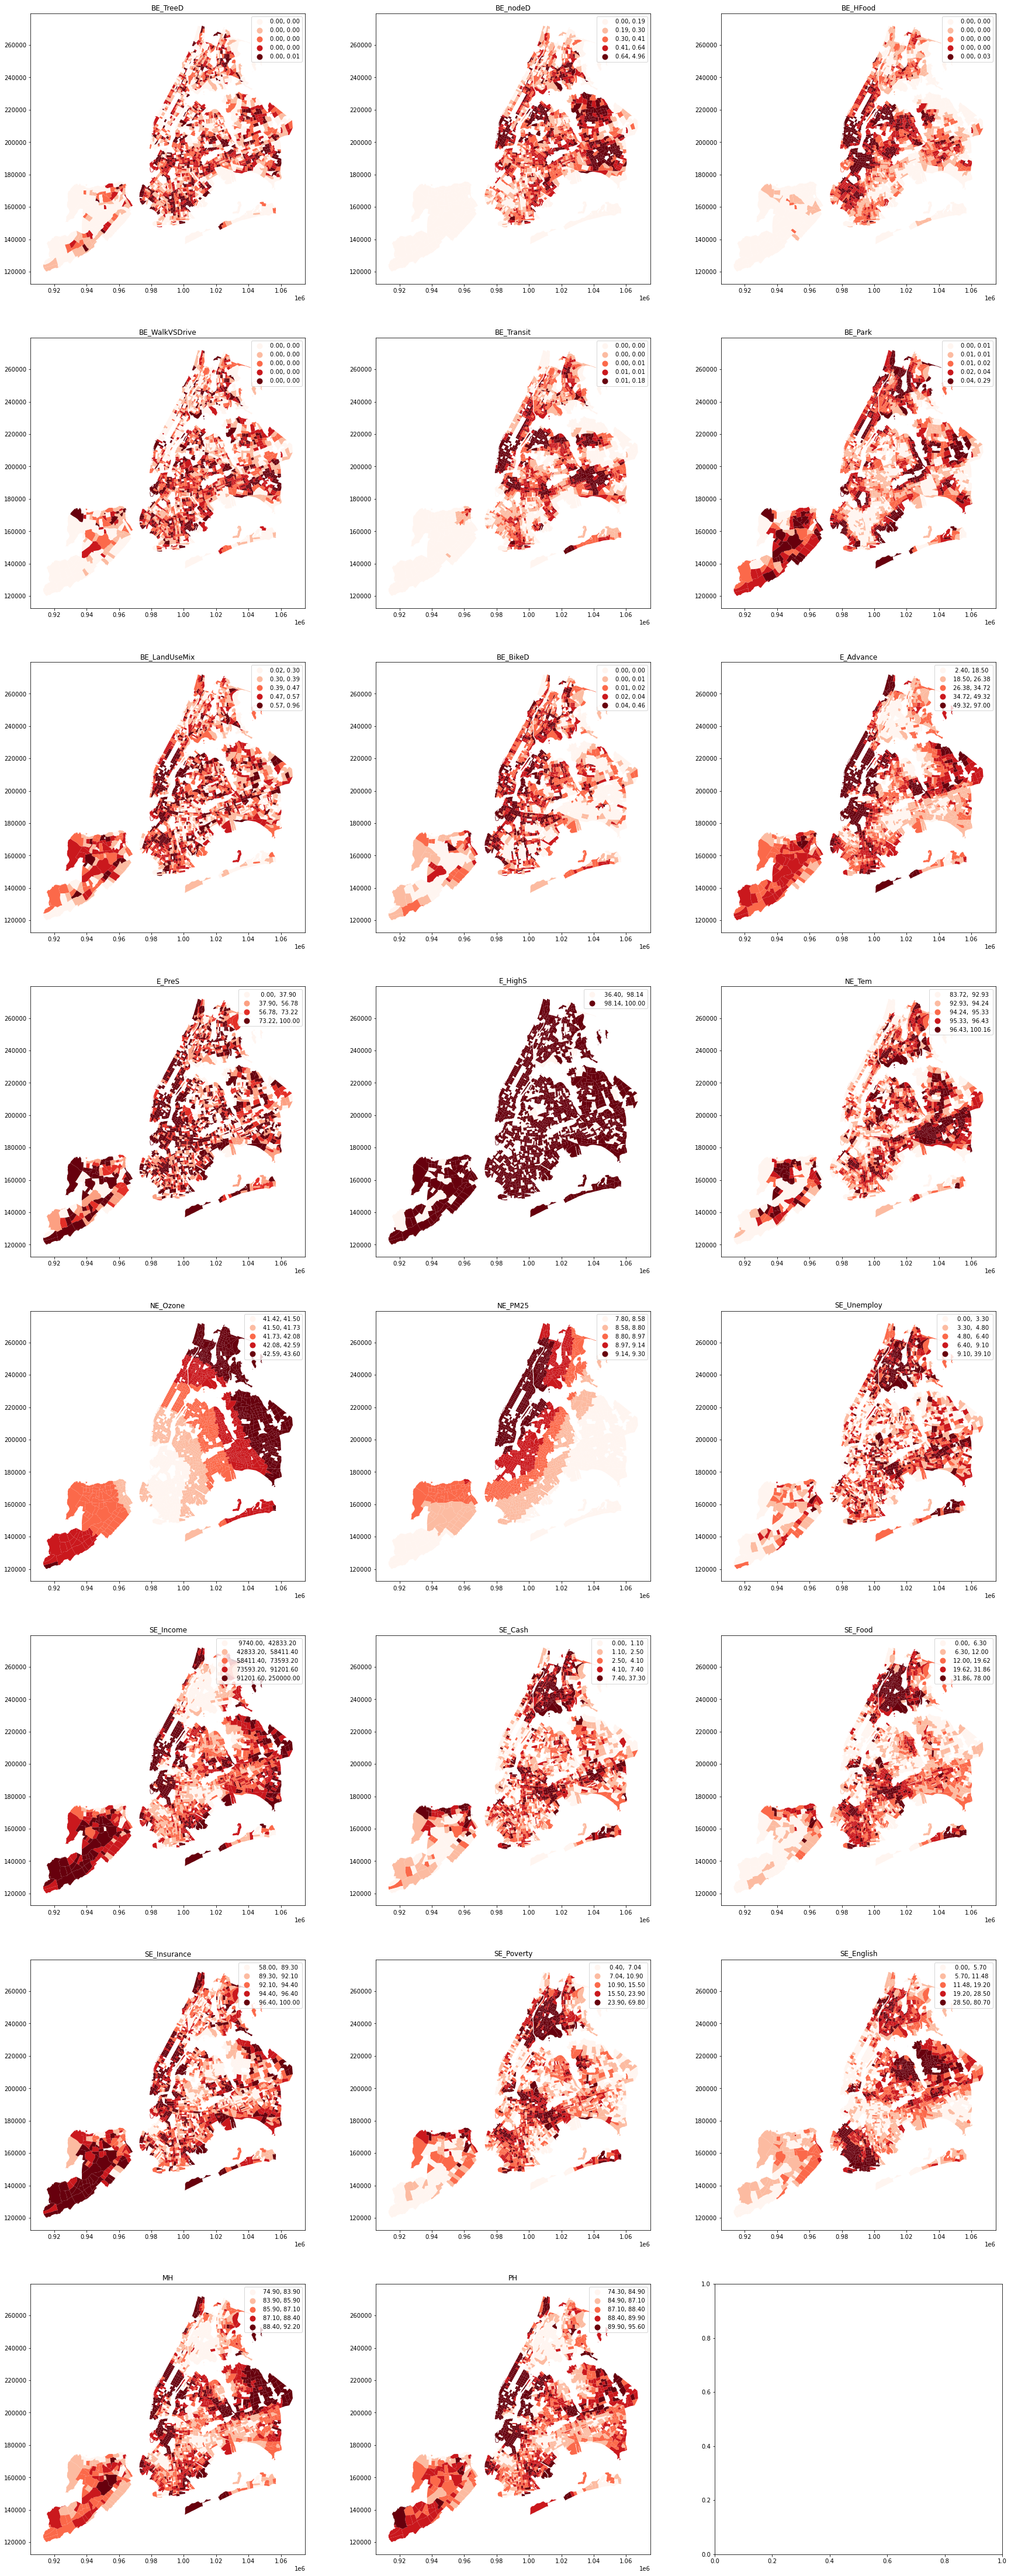

In [27]:
fig, ax = plt.subplots(8,3, figsize=(30,80))

a = dataGeo.columns[:-2]

for i,j in enumerate(a):
    dataGeo.plot(column=j, cmap='Reds', ax=ax[i//3][i%3],
                              legend=True, scheme='Quantiles', k=5,
                              figsize=(5,5))
    label = j
    ax[i//3][i%3].set_title(label)
    
plt.show()

In [28]:
fig.savefig('./Image/DataPlot.jpg', dpi=600,bbox_inches='tight')

In [19]:
dataGeo.groupby('boro_name').mean()

BE_TreeD  BE_nodeD  BE_HFood  BE_WalkVSDrive  BE_Transit  \
boro_name                                                                 
Bronx          0.001733  0.000283  0.000872        0.000108    0.006419   
Brooklyn       0.001972  0.000289  0.001962        0.000126    0.006374   
Manhattan      0.001573  0.000613  0.003901        0.000092    0.016937   
Queens         0.001813  0.000510  0.001994        0.000127    0.010676   
Staten Island  0.001126  0.000000  0.000214        0.000081    0.001240   

                BE_Park  BE_LandUseMix  BE_BikeD  E_Advance     E_PreS  \
boro_name                                                                
Bronx          0.041927       0.392606  0.022041  20.463208  59.141509   
Brooklyn       0.022950       0.443228  0.024175  36.167549  65.958357   
Manhattan      0.034445       0.509994  0.036292  60.773878  77.189388   
Queens         0.025871       0.435625  0.014561  31.500000  55.913290   
Staten Island  0.033430       0.422220  0.006843  34.080000  62.444762   

                 E_HighS     NE_Tem   NE_Ozone   NE_PM25  SE_Unemploy  \
boro_name                                                               
Bronx          96.926415  94.812282  42.730573  9.068275     9.944340   
Brooklyn       96.714206  94.339864  41.532519  8.851299     6.253343   
Manhattan      98.527755  93.384874  41.871965  9.245712     5.542857   
Queens         97.687034  95.292474  42.340310  8.575509     5.712966   
Staten Island  96.971429  94.658736  41.952838  8.735042     4.645714   

                  SE_Income   SE_Cash    SE_Food  SE_Insurance  SE_Poverty  \
boro_name                                                                    
Bronx          45448.710692  7.895912  34.864465     91.743396   23.824843   
Brooklyn       67190.771588  4.512256  21.433287     92.879805   17.174791   
Manhattan      97254.591837  3.214286  14.513878     94.977551   15.743265   
Queens         73733.743922  3.279092  12.709238     90.699676   10.862723   
Staten Island  82993.533333  4.467619  12.660952     95.417143   11.740952   

               SE_English         MH         PH  
boro_name                                        
Bronx           20.110692  83.514465  84.391824  
Brooklyn        17.962256  86.099582  87.694847  
Manhattan       10.732653  87.042449  89.153878  
Queens          21.740194  87.080551  87.789627  
Staten Island    8.898095  85.811429  87.666667

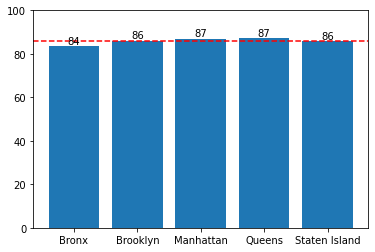

In [38]:
p1 = plt.bar(x=dataGeo.groupby('boro_name').mean().index, height=dataGeo.groupby('boro_name').mean()['MH'])
plt.bar_label(p1,label_type='edge', fmt='%.f')
plt.ylim(0,100)
plt.axhline(y=dataGeo.groupby('boro_name').mean()['MH'].mean(), ls='--', color='r')

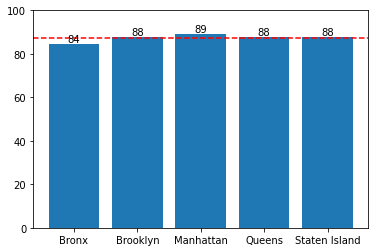

In [39]:
p2 = plt.bar(x=dataGeo.groupby('boro_name').mean().index, height=dataGeo.groupby('boro_name').mean()['PH'])
plt.bar_label(p2,label_type='edge', fmt='%.f')
plt.ylim(0,100)
plt.axhline(y=dataGeo.groupby('boro_name').mean()['PH'].mean(), ls='--', color='r')

# 2. RandomForest Model Analysis

In [235]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [226]:
data.head()

BE_TreeD  BE_nodeD  BE_HFood  BE_WalkVSDrive  BE_Transit  \
36005000200  0.001039  0.000516  0.000000        0.000062    0.001033   
36005000400  0.000862  0.000332  0.000000        0.000054    0.000610   
36005001600  0.000784  0.000353  0.000177        0.000058    0.001719   
36005001900  0.000745  0.000271  0.000578        0.000171    0.010265   
36005002000  0.000580  0.000412  0.000121        0.000049    0.001279   

              BE_Park  BE_LandUseMix  E_Advance  E_PreS  E_HighS     NE_Tem  \
36005000200  0.027208       0.160274       29.4    29.9    100.0  94.643103   
36005000400  0.014828       0.392961       28.4    53.1    100.0  92.135510   
36005001600  0.025224       0.442828       18.5    76.6     90.6  96.693606   
36005001900  0.078188       0.461624       24.6    25.3     93.6  96.796323   
36005002000  0.023708       0.274914        8.4    87.5    100.0  93.799532   

              NE_Ozone   NE_PM25  SE_Unemploy  SE_Income  SE_Cash  SE_Food  \
36005000200  42.521795  8.939136         13.5    51100.0      8.3     21.5   
36005000400  42.587127  8.902753          6.2    78409.0      7.1      8.4   
36005001600  42.587327  8.949253          4.8    34093.0      7.7     35.3   
36005001900  42.051273  9.157725         10.7    45156.0      7.7     31.6   
36005002000  42.509834  8.983487         18.9    20592.0     11.7     52.6   

             SE_Insurance  SE_Poverty  SE_English  MHLTH  PHLTH  
36005000200          93.3        23.0        15.4   13.9   13.4  
36005000400          94.9         7.7        10.8   12.4   10.8  
36005001600          93.6        25.3        17.3   16.0   16.8  
36005001900          85.2        30.4        11.1   16.6   13.9  
36005002000          91.0        42.4        13.3   20.5   21.4

In [251]:
X_all = data.iloc[:,:-2]
X_BE = data.iloc[:,:7]

In [233]:
y_MHLTH = data.MHLTH
y_PHLTH = data.PHLTH

## PHLTH: All indicators

310 0.8564975940286313 0.0034222128343180634
310 0.8564975940286313 0.0034222128343180634
310 0.8564975940286313 0.0034222128343180634 0.024015153353889564


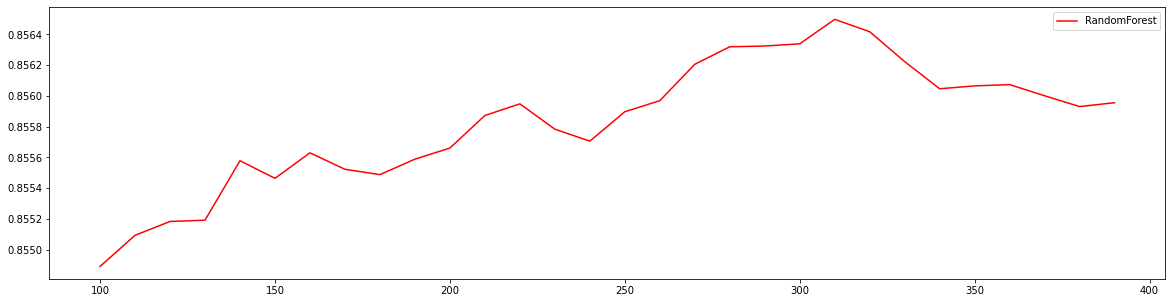

In [240]:
# Tunning n_estimators
axisx = np.arange(100,400,10)
rs = []
var = []
ge = []
for i in axisx:
    rfs = RandomForestRegressor(n_estimators=i
                                ,random_state=90)
    
    cvresult = cross_val_score(rfs,X_all,y_PHLTH,cv=10)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
    
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="RandomForest")
plt.legend()
plt.show()

16 0.8566838197276294 0.0033896197207774134
16 0.8566838197276294 0.0033896197207774134
16 0.8566838197276294 0.0033896197207774134 0.023929147248640037


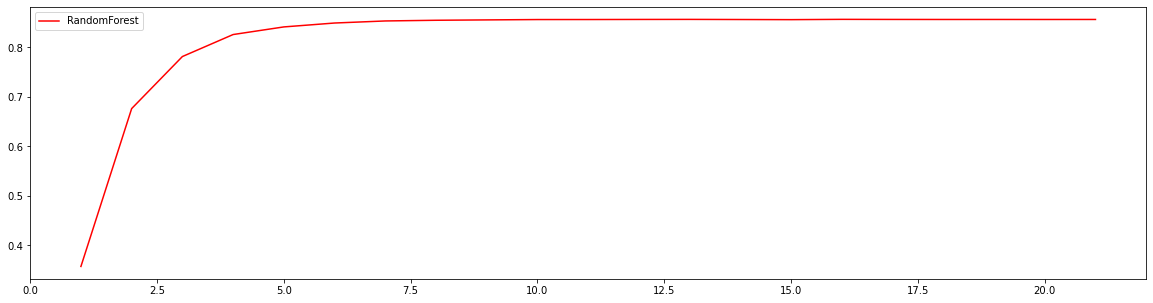

In [245]:
# Tunning max_depth
axisx = np.arange(1,22,1)
rs = []
var = []
ge = []
for i in axisx:
    rfs = RandomForestRegressor(n_estimators=310
                                ,max_depth=i
                                ,random_state=90)
    
    cvresult = cross_val_score(rfs,X_all,y_PHLTH,cv=10)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
    
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="RandomForest")
plt.legend()
plt.show()

In [246]:
# best model (our objective is not predict anything, just see the feature importance)
rfs = RandomForestRegressor(n_estimators=310,
                                max_depth=16,
                                n_jobs=-1,
                                random_state=90).fit(X_all,y_PHLTH)

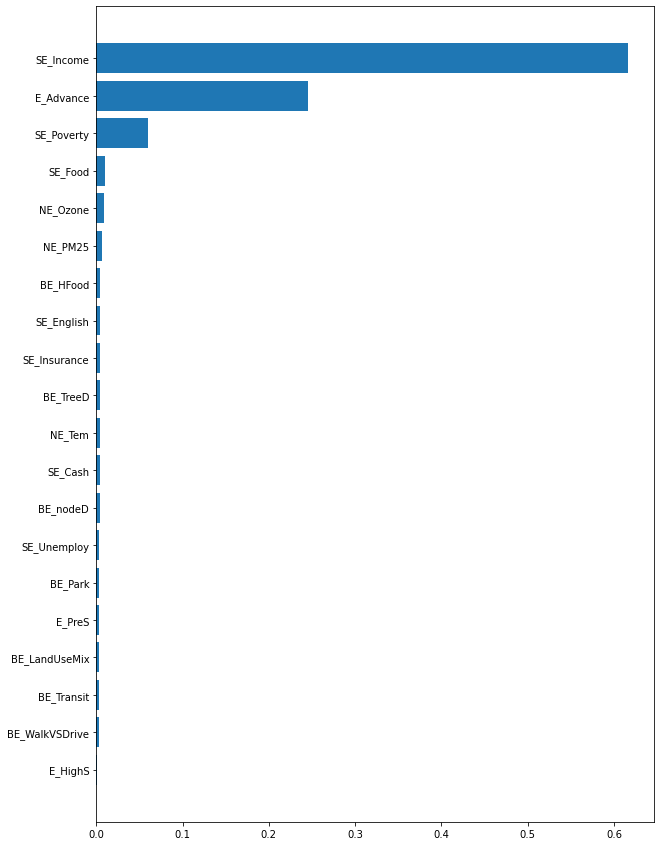

In [247]:
feature_imp = pd.DataFrame({'name':X_all.columns, 'value':rfs.feature_importances_}).sort_values(by='value',ascending=True)
plot, ax = plt.subplots(1,1,figsize = (10,15))
plt.barh(feature_imp.name, feature_imp.value)
plt.show()

## MHLTH: All indicators

300 0.7713396151777783 0.009546137459403933
160 0.7692161150425314 0.009405565240129764
300 0.7713396151777783 0.009546137459403933 0.06183170904645047


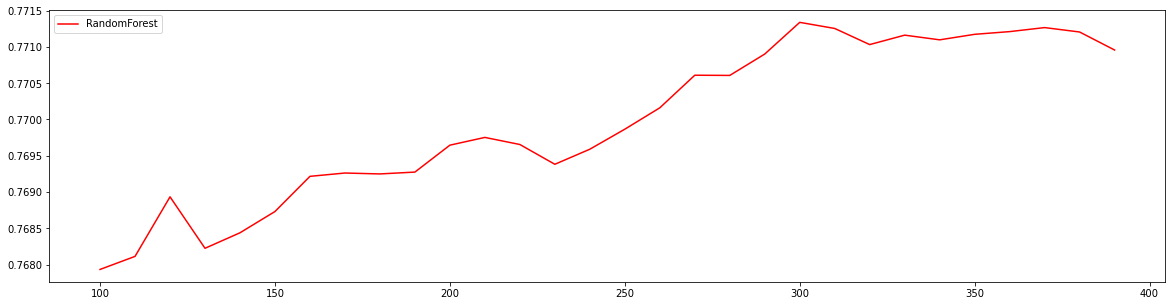

In [258]:
# Tunning n_estimators
axisx = np.arange(100,400,10)
rs = []
var = []
ge = []
for i in axisx:
    rfs = RandomForestRegressor(n_estimators=i
                                ,random_state=90)
    
    cvresult = cross_val_score(rfs,X_all,y_MHLTH,cv=10)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
    
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="RandomForest")
plt.legend()
plt.show()

16 0.7721653654695817 0.009375526224679197
16 0.7721653654695817 0.009375526224679197
16 0.7721653654695817 0.009375526224679197 0.06128414691628847


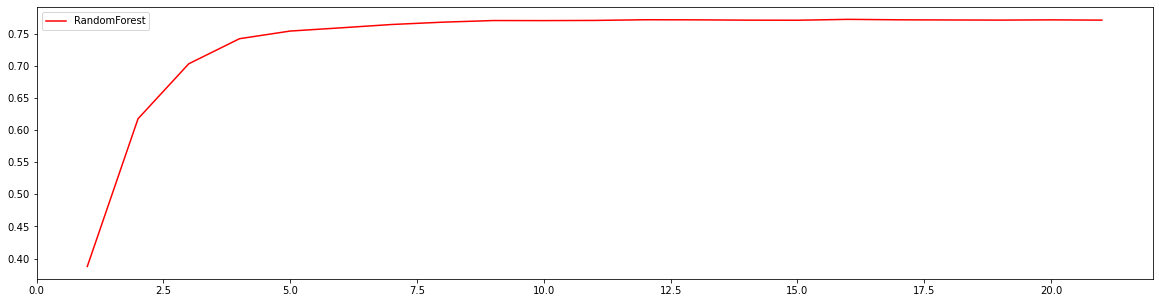

In [259]:
# Tunning max_depth
axisx = np.arange(1,22,1)
rs = []
var = []
ge = []
for i in axisx:
    rfs = RandomForestRegressor(n_estimators=300
                                ,max_depth=i
                                ,random_state=90)
    
    cvresult = cross_val_score(rfs,X_all,y_MHLTH,cv=10)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
    
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="RandomForest")
plt.legend()
plt.show()

In [260]:
# our objective is not predict anything, just see the feature importance
rfs = RandomForestRegressor(n_estimators=300
                            ,max_depth=16
                           ,random_state=90).fit(X_all,y_MHLTH)

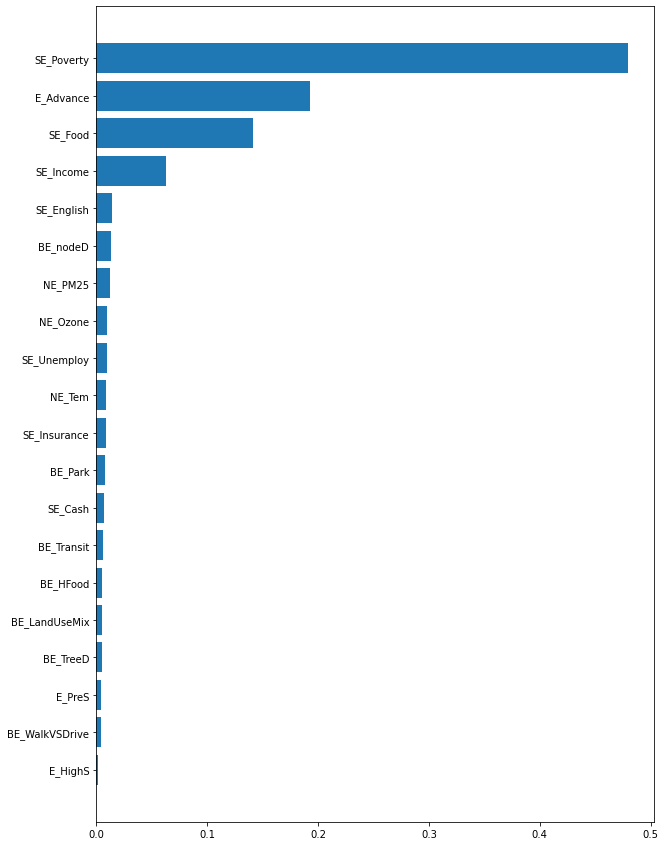

In [261]:
feature_imp = pd.DataFrame({'name':X_all.columns, 'value':rfs.feature_importances_}).sort_values(by='value',ascending=True)
plot, ax = plt.subplots(1,1,figsize = (10,15))
plt.barh(feature_imp.name, feature_imp.value)
plt.show()

## PHLTH: Built-Environment

In [252]:
rfs = RandomForestRegressor().fit(X_BE,y_PHLTH)

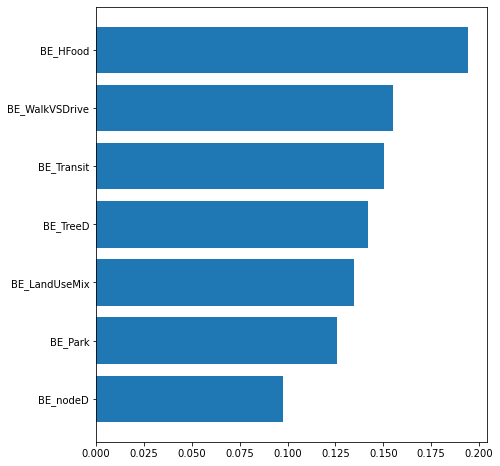

In [254]:
feature_imp = pd.DataFrame({'name':X_BE.columns, 'value':rfs.feature_importances_}).sort_values(by='value',ascending=True)
plot, ax = plt.subplots(1,1,figsize = (7,8))
plt.barh(feature_imp.name, feature_imp.value)
plt.show()

## MHLTH: Built-Environment

In [256]:
rfs = RandomForestRegressor().fit(X_BE,y_MHLTH)

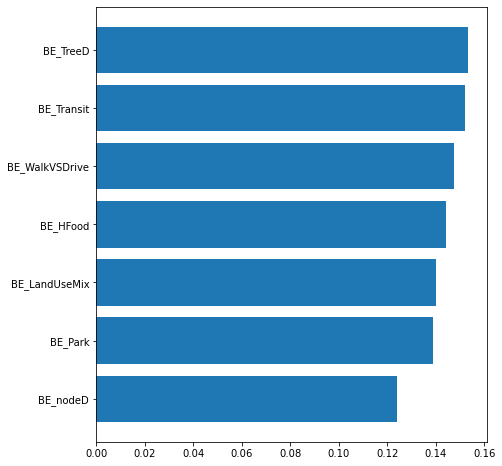

In [257]:
feature_imp = pd.DataFrame({'name':X_BE.columns, 'value':rfs.feature_importances_}).sort_values(by='value',ascending=True)
plot, ax = plt.subplots(1,1,figsize = (7,8))
plt.barh(feature_imp.name, feature_imp.value)
plt.show()

# 3. Calculate Score

## Indicators Weight

In [96]:
# filter out E_HighS, not significant. and SE_Cash SE_Food because they are highly correlate with income and poverty

In [297]:
df_Z = data_Z.drop(columns=['E_HighS','SE_Cash','SE_Food','SE_Income'])
df_Z.head()

BE_TreeD  BE_HFood   BE_Park  BE_LandUseMix  BE_WalkVSDrive  BE_nodeD  \
0 -0.662373 -0.842791 -0.045052      -1.730821       -0.903941 -0.396696   
1 -0.818237 -0.842791 -0.391468      -0.290617       -1.036105 -0.531006   
2 -0.887313 -0.765981 -0.100558       0.018036       -0.970307  0.001192   
3 -0.921100 -0.592375  1.381428       0.134369        0.906876 -0.041036   
4 -1.066606 -0.790389 -0.142972      -1.021263       -1.127281 -0.469709   

   BE_Transit  BE_BikeD  E_Advance    E_PreS    NE_Tem  NE_Ozone   NE_PM25  \
0   -0.740547 -0.549264  -0.283513 -1.147894  0.015916  0.901082  0.307798   
1   -0.781240  0.113004  -0.332932 -0.342632 -1.127930  1.022041  0.191383   
2   -0.674569 -0.301096  -0.822187  0.473043  0.951260  1.022411  0.340169   
3    0.147751  0.283459  -0.520727 -1.307558  0.998114  0.029927  1.007231   
4   -0.716906 -0.588386  -1.321325  0.851378 -0.368881  0.878936  0.449710   

   SE_Unemploy  SE_Insurance  SE_Poverty  SE_English        MH        PH  
0     1.637542      0.176725    0.684679   -0.197051  0.002955 -0.226785  
1    -0.070595      0.497105   -0.775590   -0.531820  0.528212  0.532441  
2    -0.398182      0.236796    0.904196   -0.058777 -0.732407 -1.219620  
3     0.982366     -1.445200    1.390952   -0.509987 -0.942510 -0.372790  
4     2.901095     -0.283822    2.536261   -0.349880 -2.308180 -2.562867

In [298]:
# reversed features have negative correlation with health 
reverse = ['NE_Tem', 'NE_Ozone', 'NE_PM25', 'SE_Unemploy', 'SE_Poverty', 'SE_English']
df_Z[reverse] = df_Z[reverse]*-1
df_Z.head()

BE_TreeD  BE_HFood   BE_Park  BE_LandUseMix  BE_WalkVSDrive  BE_nodeD  \
0 -0.662373 -0.842791 -0.045052      -1.730821       -0.903941 -0.396696   
1 -0.818237 -0.842791 -0.391468      -0.290617       -1.036105 -0.531006   
2 -0.887313 -0.765981 -0.100558       0.018036       -0.970307  0.001192   
3 -0.921100 -0.592375  1.381428       0.134369        0.906876 -0.041036   
4 -1.066606 -0.790389 -0.142972      -1.021263       -1.127281 -0.469709   

   BE_Transit  BE_BikeD  E_Advance    E_PreS    NE_Tem  NE_Ozone   NE_PM25  \
0   -0.740547 -0.549264  -0.283513 -1.147894 -0.015916 -0.901082 -0.307798   
1   -0.781240  0.113004  -0.332932 -0.342632  1.127930 -1.022041 -0.191383   
2   -0.674569 -0.301096  -0.822187  0.473043 -0.951260 -1.022411 -0.340169   
3    0.147751  0.283459  -0.520727 -1.307558 -0.998114 -0.029927 -1.007231   
4   -0.716906 -0.588386  -1.321325  0.851378  0.368881 -0.878936 -0.449710   

   SE_Unemploy  SE_Insurance  SE_Poverty  SE_English        MH        PH  
0    -1.637542      0.176725   -0.684679    0.197051  0.002955 -0.226785  
1     0.070595      0.497105    0.775590    0.531820  0.528212  0.532441  
2     0.398182      0.236796   -0.904196    0.058777 -0.732407 -1.219620  
3    -0.982366     -1.445200   -1.390952    0.509987 -0.942510 -0.372790  
4    -2.901095     -0.283822   -2.536261    0.349880 -2.308180 -2.562867

In [299]:
data_weight = df_Z.corr().iloc[:-2,-2:]
data_weight = data_weight.round(decimals=2)
data_weight

MH    PH
BE_TreeD        0.18  0.18
BE_HFood        0.20  0.28
BE_Park         0.11  0.07
BE_LandUseMix   0.14  0.21
BE_WalkVSDrive  0.10  0.08
BE_nodeD        0.14  0.12
BE_Transit      0.11  0.15
BE_BikeD        0.05  0.09
E_Advance       0.73  0.81
E_PreS          0.07  0.14
NE_Tem          0.19  0.17
NE_Ozone        0.09  0.20
NE_PM25         0.15 -0.00
SE_Unemploy     0.55  0.57
SE_Insurance    0.23  0.27
SE_Poverty      0.83  0.81
SE_English      0.19  0.38

In [302]:
data_weight['Average_Coef'] = ((data_weight['MH'] + data_weight['PH'])/2)
data_weight

MH    PH  Average_Coef
BE_TreeD        0.18  0.18         0.180
BE_HFood        0.20  0.28         0.240
BE_Park         0.11  0.07         0.090
BE_LandUseMix   0.14  0.21         0.175
BE_WalkVSDrive  0.10  0.08         0.090
BE_nodeD        0.14  0.12         0.130
BE_Transit      0.11  0.15         0.130
BE_BikeD        0.05  0.09         0.070
E_Advance       0.73  0.81         0.770
E_PreS          0.07  0.14         0.105
NE_Tem          0.19  0.17         0.180
NE_Ozone        0.09  0.20         0.145
NE_PM25         0.15 -0.00         0.075
SE_Unemploy     0.55  0.57         0.560
SE_Insurance    0.23  0.27         0.250
SE_Poverty      0.83  0.81         0.820
SE_English      0.19  0.38         0.285

In [303]:
data_weight.iloc[0:4,2]

BE_TreeD         0.180
BE_HFood         0.240
BE_Park          0.090
BE_LandUseMix    0.175
Name: Average_Coef, dtype: float64

In [304]:
data_weight.iloc[4:8,2]

BE_WalkVSDrive    0.09
BE_nodeD          0.13
BE_Transit        0.13
BE_BikeD          0.07
Name: Average_Coef, dtype: float64

In [305]:
data_weight.iloc[8:10,2]

E_Advance    0.770
E_PreS       0.105
Name: Average_Coef, dtype: float64

In [306]:
data_weight.iloc[10:13,2]

NE_Tem      0.180
NE_Ozone    0.145
NE_PM25     0.075
Name: Average_Coef, dtype: float64

In [307]:
data_weight.iloc[13:,2]

SE_Unemploy     0.560
SE_Insurance    0.250
SE_Poverty      0.820
SE_English      0.285
Name: Average_Coef, dtype: float64

## Domain Score

In [308]:
# domain weight
data_weight['Final_Weight'] = 0
data_weight['Final_Weight'][0:4] = data_weight.iloc[0:4,2]/data_weight.iloc[0:4,2].sum()
data_weight['Final_Weight'][4:8] = data_weight.iloc[4:8,2]/data_weight.iloc[4:8,2].sum()
data_weight['Final_Weight'][8:10] = data_weight.iloc[8:10,2]/data_weight.iloc[8:10,2].sum()
data_weight['Final_Weight'][10:13] = abs(data_weight.iloc[10:13,2])/abs(data_weight.iloc[10:13,2]).sum()
data_weight['Final_Weight'][13:] = abs(data_weight.iloc[13:,2])/abs(data_weight.iloc[13:,2]).sum()
data_weight['Final_Weight'] = data_weight.Final_Weight.round(decimals=3)
data_weight

/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


MH    PH  Average_Coef  Final_Weight
BE_TreeD        0.18  0.18         0.180         0.263
BE_HFood        0.20  0.28         0.240         0.350
BE_Park         0.11  0.07         0.090         0.131
BE_LandUseMix   0.14  0.21         0.175         0.255
BE_WalkVSDrive  0.10  0.08         0.090         0.214
BE_nodeD        0.14  0.12         0.130         0.310
BE_Transit      0.11  0.15         0.130         0.310
BE_BikeD        0.05  0.09         0.070         0.167
E_Advance       0.73  0.81         0.770         0.880
E_PreS          0.07  0.14         0.105         0.120
NE_Tem          0.19  0.17         0.180         0.450
NE_Ozone        0.09  0.20         0.145         0.363
NE_PM25         0.15 -0.00         0.075         0.187
SE_Unemploy     0.55  0.57         0.560         0.292
SE_Insurance    0.23  0.27         0.250         0.131
SE_Poverty      0.83  0.81         0.820         0.428
SE_English      0.19  0.38         0.285         0.149

In [309]:
data_weight['Final_Weight'][0:4].sum()

0.999

In [310]:
data_weight['Final_Weight'][4:8].sum()

1.0010000000000001

In [311]:
data_weight['Final_Weight'][8:10].sum()

1.0

In [312]:
data_weight['Final_Weight'][10:13].sum()

1.0

In [313]:
data_weight['Final_Weight'][13:].sum()

1.0

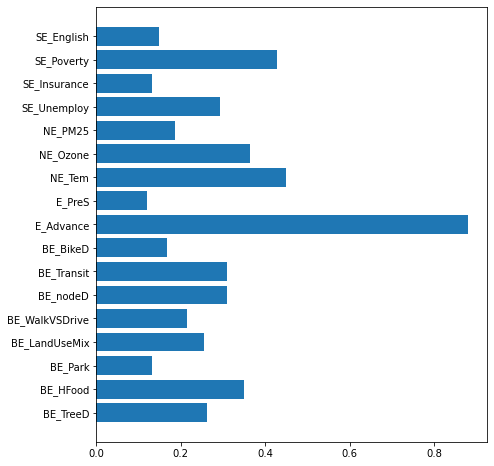

In [314]:
plot, ax = plt.subplots(1,1,figsize = (7,8))
plt.barh(data_weight.index, data_weight.Final_Weight)
plt.show()

In [315]:
df_Score = pd.DataFrame()
for i in df_Z.columns[:-2]:
    df_Score[i] = df_Z[i]*data_weight.loc[i,'Final_Weight']
df_Score

BE_TreeD  BE_HFood   BE_Park  BE_LandUseMix  BE_WalkVSDrive  BE_nodeD  \
0    -0.174204 -0.294977 -0.005902      -0.441359       -0.193443 -0.122976   
1    -0.215196 -0.294977 -0.051282      -0.074107       -0.221727 -0.164612   
2    -0.233363 -0.268093 -0.013173       0.004599       -0.207646  0.000369   
3    -0.242249 -0.207331  0.180967       0.034264        0.194071 -0.012721   
4    -0.280517 -0.276636 -0.018729      -0.260422       -0.241238 -0.145610   
...        ...       ...       ...            ...             ...       ...   
1998 -0.288889 -0.245407 -0.092104      -0.087675       -0.264476 -0.360725   
1999 -0.103452 -0.202049 -0.036945      -0.138012        0.003415 -0.360725   
2000 -0.276061 -0.272625 -0.030062      -0.176881       -0.192814 -0.360725   
2001 -0.370577 -0.190951  0.112653      -0.010966        0.198645 -0.360725   
2002 -0.414690 -0.183576 -0.004598      -0.175643       -0.319483 -0.077729   

      BE_Transit  BE_BikeD  E_Advance    E_PreS    NE_Tem  NE_Ozone   NE_PM25  \
0      -0.229569 -0.091727  -0.249491 -0.137747 -0.007162 -0.327093 -0.057558   
1      -0.242184  0.018872  -0.292981 -0.041116  0.507569 -0.371001 -0.035789   
2      -0.209116 -0.050283  -0.723524  0.056765 -0.428067 -0.371135 -0.063612   
3       0.045803  0.047338  -0.458240 -0.156907 -0.449151 -0.010864 -0.188352   
4      -0.222241 -0.098260  -1.162766  0.102165  0.165997 -0.319054 -0.084096   
...          ...       ...        ...       ...       ...       ...       ...   
1998   -0.260392 -0.118448  -0.219049  0.086338 -0.409477  0.054002 -0.018323   
1999   -0.260392 -0.033033  -0.801805 -0.262285 -0.343950  0.058699 -0.034880   
2000   -0.260392 -0.118448  -0.345168 -0.127334 -0.352865  0.066257 -0.048141   
2001   -0.260392 -0.066517  -0.680035  0.154230  0.592358  0.039794 -0.044419   
2002   -0.095193  0.134224  -1.080137  0.060097  0.476332 -0.354325 -0.226952   

      SE_Unemploy  SE_Insurance  SE_Poverty  SE_English  
0       -0.478162      0.023151   -0.293043    0.029361  
1        0.020614      0.065121    0.331952    0.079241  
2        0.116269      0.031020   -0.386996    0.008758  
3       -0.286851     -0.189321   -0.595328    0.075988  
4       -0.847120     -0.037181   -1.085520    0.052132  
...           ...           ...         ...         ...  
1998     0.068441      0.065121    0.033752    0.108519  
1999     0.041111      0.099221   -0.775065    0.100928  
2000     0.300748      0.065121   -0.501374    0.122616  
2001     0.225590      0.083483   -0.244023    0.112856  
2002    -1.393723      0.028397   -1.571627    0.073819  

[2003 rows x 17 columns]

In [316]:
df_Domain_Score = pd.DataFrame()
df_Domain_Score['NB'] = df_Score.iloc[:,0:4].sum(axis=1)
df_Domain_Score['TP'] = df_Score.iloc[:,4:8].sum(axis=1)
df_Domain_Score['E'] = df_Score.iloc[:,8:10].sum(axis=1)
df_Domain_Score['NE'] = df_Score.iloc[:,10:13].sum(axis=1)
df_Domain_Score['SE'] = df_Score.iloc[:,13:].sum(axis=1)
df_Domain_Score

NB        TP         E        NE        SE
0    -0.916442 -0.637716 -0.387239 -0.391813 -0.718693
1    -0.635563 -0.609651 -0.334096  0.100779  0.496928
2    -0.510030 -0.466676 -0.666759 -0.862814 -0.230949
3    -0.234349  0.274491 -0.615147 -0.648367 -0.995512
4    -0.836305 -0.707349 -1.060601 -0.237153 -1.917688
...        ...       ...       ...       ...       ...
1998 -0.714075 -1.004041 -0.132711 -0.373798  0.275833
1999 -0.480458 -0.650735 -1.064090 -0.320131 -0.533804
2000 -0.755629 -0.932379 -0.472502 -0.334749 -0.012890
2001 -0.459841 -0.488989 -0.525805  0.587733  0.177905
2002 -0.778507 -0.358181 -1.020039 -0.104945 -2.863134

[2003 rows x 5 columns]

In [317]:
df_Domain_Score.describe()

NB            TP             E            NE            SE
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03
mean   8.070318e-17  1.427548e-16  7.383011e-17 -1.920331e-15  3.294641e-16
std    6.431556e-01  7.921890e-01  9.149289e-01  5.814136e-01  7.267975e-01
min   -1.236522e+00 -1.070181e+00 -1.582385e+00 -1.621727e+00 -3.954617e+00
25%   -4.248271e-01 -4.909523e-01 -6.515689e-01 -4.219113e-01 -4.159713e-01
50%   -1.178547e-01 -1.947851e-01 -2.213067e-01 -1.170927e-02  1.194708e-01
75%    2.693793e-01  2.337673e-01  4.197204e-01  4.025920e-01  5.401785e-01
max    5.316835e+00  8.049673e+00  2.844614e+00  2.591120e+00  1.318587e+00

In [318]:
# Z-score transform
Domain_scaler = StandardScaler().fit(df_Domain_Score)     
Domain_scale = Domain_scaler.transform(df_Domain_Score) 
df_Domain_Score_Z = pd.DataFrame(Domain_scale)
df_Domain_Score_Z.columns = df_Domain_Score.columns
df_Domain_Score_Z.head()

NB        TP         E        NE        SE
0 -1.425271 -0.805206 -0.423350 -0.674066 -0.989096
1 -0.988441 -0.769770 -0.365252  0.173378  0.683893
2 -0.793210 -0.589243 -0.728937 -1.484363 -0.317841
3 -0.364465  0.346583 -0.672512 -1.115435 -1.370066
4 -1.300640 -0.893128 -1.159506 -0.407992 -2.639204

In [319]:
df_Domain_Score_Z.describe()

NB            TP             E            NE            SE
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03
mean  -7.671236e-17 -5.872598e-17  2.704887e-17 -6.501705e-17 -5.542801e-18
std    1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00
min   -1.923067e+00 -1.351254e+00 -1.729949e+00 -2.789979e+00 -5.442512e+00
25%   -6.607004e-01 -6.198962e-01 -7.123303e-01 -7.258459e-01 -5.724774e-01
50%   -1.832903e-01 -2.459436e-01 -2.419444e-01 -2.014434e-02  1.644208e-01
75%    4.189447e-01  2.951640e-01  4.588610e-01  6.926094e-01  7.434167e-01
max    8.268859e+00  1.016384e+01  3.109886e+00  4.457699e+00  1.814696e+00

[1, 0]
[4, 2]
[5, 2]
[5, 4]
[6, 2]
[6, 4]
[6, 5]


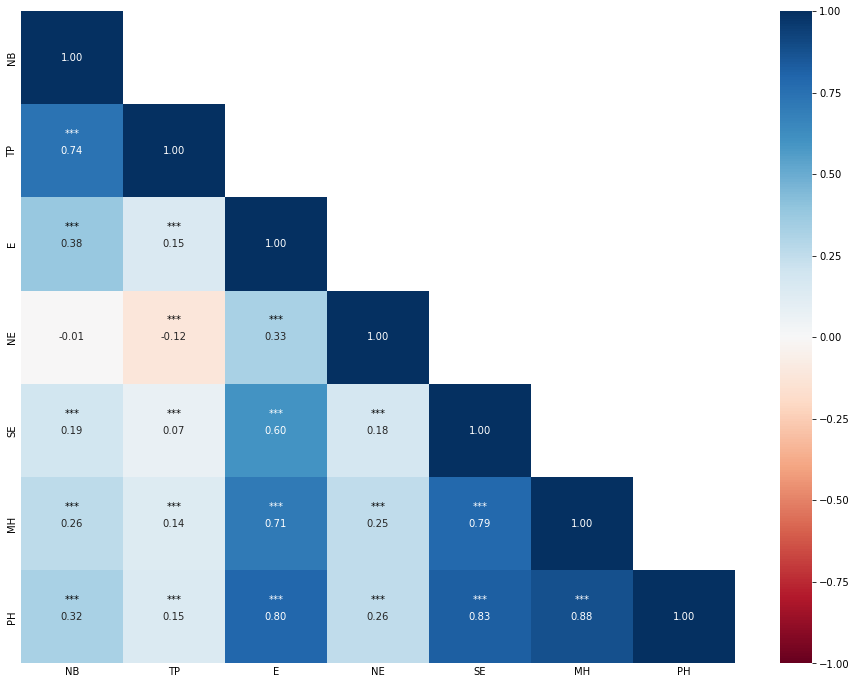

In [320]:
df_coor=pd.concat([df_Domain_Score_Z, df_Z[['MH','PH']]], axis=1).corr()
fig = plt.figure(figsize=(16,12))
ax1 = plt.gca()

#构造mask，去除重复数据显示
mask = np.zeros_like(df_coor)
mask[np.triu_indices_from(mask)] = True
mask2 = mask
mask = (np.flipud(mask)-1)*(-1)
mask = np.rot90(mask,k = -1)

im1 = sns.heatmap(df_coor,annot=True,cmap="RdBu"
, mask=mask#构造mask，去除重复数据显示
,vmax=1,vmin=-1
, fmt='.2f',ax = ax1)

ax1.tick_params(axis = 'both', length=0)

#计算相关性显著性并显示
df = pd.concat([df_Domain_Score_Z, df_Z[['MH','PH']]], axis=1)
rlist = []
plist = []
for i in df.columns.values:
    for j in df.columns.values:
        r,p = pearsonr(df[i],df[j])
        rlist.append(r)
        plist.append(p)

rarr = np.asarray(rlist).reshape(len(df.columns.values),len(df.columns.values))
parr = np.asarray(plist).reshape(len(df.columns.values),len(df.columns.values))
xlist = ax1.get_xticks()
ylist = ax1.get_yticks()

widthx = 0
widthy = -0.15

for m in ax1.get_xticks():
    for n in ax1.get_yticks():
        pv = (parr[int(m),int(n)])
        rv = (rarr[int(m),int(n)])
        if mask2[int(m),int(n)]<1.:
            if abs(rv) > 0.5:
                if  pv< 0.05 and pv>= 0.01:
                    ax1.text(n+widthx,m+widthy,'*',ha = 'center',color = 'white')
                if  pv< 0.01 and pv>= 0.001:
                    ax1.text(n+widthx,m+widthy,'**',ha = 'center',color = 'white')
                if  pv< 0.001:
                    print([int(m),int(n)])
                    ax1.text(n+widthx,m+widthy,'***',ha = 'center',color = 'white')
            else: 
                if  pv< 0.05 and pv>= 0.01:
                    ax1.text(n+widthx,m+widthy,'*',ha = 'center',color = 'k')
                elif  pv< 0.01 and pv>= 0.001:
                    ax1.text(n+widthx,m+widthy,'**',ha = 'center',color = 'k')
                elif  pv< 0.001:
                    ax1.text(n+widthx,m+widthy,'***',ha = 'center',color = 'k')
#plt.savefig(r'Z:\GJ\pearsonr\fig\r_demo.png',dpi=600)
plt.show()

## Domain Weight

In [325]:
data_Domain_weight = pd.concat([df_Domain_Score_Z, df_Z[['MH','PH']]], axis=1).corr().iloc[:-2,-2:].round(decimals=2)
data_Domain_weight['Averge_Domain_Weight'] = ((data_Domain_weight['MH']+data_Domain_weight['PH'])/2).round(decimals=2)
data_Domain_weight

MH    PH  Averge_Domain_Weight
NB  0.26  0.32                  0.29
TP  0.14  0.15                  0.15
E   0.71  0.80                  0.76
NE  0.25  0.26                  0.26
SE  0.79  0.83                  0.81

In [326]:
data_Domain_weight['Final_Domain_Weight'] = (data_Domain_weight['Averge_Domain_Weight']/data_Domain_weight['Averge_Domain_Weight'].sum()).round(decimals=2)
data_Domain_weight

MH    PH  Averge_Domain_Weight  Final_Domain_Weight
NB  0.26  0.32                  0.29                 0.13
TP  0.14  0.15                  0.15                 0.07
E   0.71  0.80                  0.76                 0.33
NE  0.25  0.26                  0.26                 0.11
SE  0.79  0.83                  0.81                 0.36

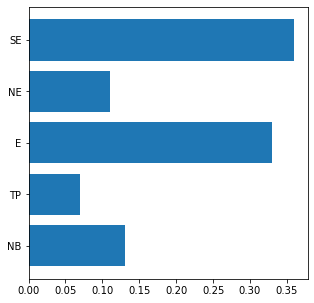

In [327]:
plot, ax = plt.subplots(1,1,figsize = (5,5))
plt.barh(data_Domain_weight.index, data_Domain_weight.Final_Domain_Weight)
plt.show()

In [328]:
data_Domain_weight['Final_Domain_Weight'].sum()

1.0

## Healthy Corridor Index

In [329]:
df_Domain_Score_Z.head()

NB        TP         E        NE        SE
0 -1.425271 -0.805206 -0.423350 -0.674066 -0.989096
1 -0.988441 -0.769770 -0.365252  0.173378  0.683893
2 -0.793210 -0.589243 -0.728937 -1.484363 -0.317841
3 -0.364465  0.346583 -0.672512 -1.115435 -1.370066
4 -1.300640 -0.893128 -1.159506 -0.407992 -2.639204

In [330]:
df_HCI = pd.DataFrame()
for i in df_Domain_Score_Z.columns:
    df_HCI[i] = df_Domain_Score_Z[i]*data_Domain_weight.loc[i, 'Final_Domain_Weight']
df_HCI

NB        TP         E        NE        SE
0    -0.185285 -0.056364 -0.139706 -0.074147 -0.356075
1    -0.128497 -0.053884 -0.120533  0.019072  0.246202
2    -0.103117 -0.041247 -0.240549 -0.163280 -0.114423
3    -0.047380  0.024261 -0.221929 -0.122698 -0.493224
4    -0.169083 -0.062519 -0.382637 -0.044879 -0.950113
...        ...       ...       ...       ...       ...
1998 -0.144371 -0.088742 -0.047879 -0.070738  0.136661
1999 -0.097138 -0.057515 -0.383896 -0.060582 -0.264472
2000 -0.152772 -0.082408 -0.170466 -0.063348 -0.006386
2001 -0.092970 -0.043219 -0.189697  0.111223  0.088143
2002 -0.157398 -0.031658 -0.368003 -0.019860 -1.418532

[2003 rows x 5 columns]

In [331]:
df_HCI['HCI'] = df_HCI.sum(axis=1)
df_HCI

NB        TP         E        NE        SE       HCI
0    -0.185285 -0.056364 -0.139706 -0.074147 -0.356075 -0.811577
1    -0.128497 -0.053884 -0.120533  0.019072  0.246202 -0.037641
2    -0.103117 -0.041247 -0.240549 -0.163280 -0.114423 -0.662617
3    -0.047380  0.024261 -0.221929 -0.122698 -0.493224 -0.860970
4    -0.169083 -0.062519 -0.382637 -0.044879 -0.950113 -1.609232
...        ...       ...       ...       ...       ...       ...
1998 -0.144371 -0.088742 -0.047879 -0.070738  0.136661 -0.215069
1999 -0.097138 -0.057515 -0.383896 -0.060582 -0.264472 -0.863603
2000 -0.152772 -0.082408 -0.170466 -0.063348 -0.006386 -0.475382
2001 -0.092970 -0.043219 -0.189697  0.111223  0.088143 -0.126520
2002 -0.157398 -0.031658 -0.368003 -0.019860 -1.418532 -1.995451

[2003 rows x 6 columns]

In [332]:
df_HCI.describe()

NB            TP             E            NE            SE  \
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   
mean  -1.163988e-18 -4.326849e-18 -2.469318e-17 -2.438659e-17 -2.904428e-17   
std    1.300325e-01  7.001748e-02  3.300824e-01  1.100275e-01  3.600899e-01   
min   -2.499987e-01 -9.458779e-02 -5.708831e-01 -3.068977e-01 -1.959304e+00   
25%   -8.589106e-02 -4.339273e-02 -2.350690e-01 -7.984305e-02 -2.060919e-01   
50%   -2.382774e-02 -1.721605e-02 -7.984166e-02 -2.215878e-03  5.919149e-02   
75%    5.446281e-02  2.066148e-02  1.514241e-01  7.618703e-02  2.676300e-01   
max    1.074952e+00  7.114689e-01  1.026262e+00  4.903469e-01  6.532906e-01   

                HCI  
count  2.003000e+03  
mean   2.283634e-17  
std    7.244994e-01  
min   -2.407663e+00  
25%   -4.423360e-01  
50%   -3.955034e-02  
75%    4.046720e-01  
max    2.384366e+00

In [333]:
# Z-score transform
HCI_scaler = StandardScaler().fit(df_HCI)     
HCI_scale = HCI_scaler.transform(df_HCI) 
df_HCI_Score_Z = pd.DataFrame(HCI_scale)
df_HCI_Score_Z.columns = df_HCI.columns
df_HCI_Score_Z = df_HCI_Score_Z[['HCI']]
df_HCI_Score_Z.head()

HCI
0 -1.120470
1 -0.051968
2 -0.914814
3 -1.188662
4 -2.221718

In [334]:
df_HCI_Score_Z.describe()

HCI
count  2.003000e+03
mean  -4.522926e-17
std    1.000250e+00
min   -3.324038e+00
25%   -6.106926e-01
50%   -5.460351e-02
75%    5.586934e-01
max    3.291875e+00

## Combine all the Data

In [335]:
HCI = pd.concat([df_HCI_Score_Z, df_Domain_Score_Z, df_Z], axis=1).set_index(data.index)
HCI.head()

HCI        NB        TP         E        NE        SE  \
36005000200 -1.120470 -1.425271 -0.805206 -0.423350 -0.674066 -0.989096   
36005000400 -0.051968 -0.988441 -0.769770 -0.365252  0.173378  0.683893   
36005001600 -0.914814 -0.793210 -0.589243 -0.728937 -1.484363 -0.317841   
36005001900 -1.188662 -0.364465  0.346583 -0.672512 -1.115435 -1.370066   
36005002000 -2.221718 -1.300640 -0.893128 -1.159506 -0.407992 -2.639204   

             BE_TreeD  BE_HFood   BE_Park  BE_LandUseMix  BE_WalkVSDrive  \
36005000200 -0.662373 -0.842791 -0.045052      -1.730821       -0.903941   
36005000400 -0.818237 -0.842791 -0.391468      -0.290617       -1.036105   
36005001600 -0.887313 -0.765981 -0.100558       0.018036       -0.970307   
36005001900 -0.921100 -0.592375  1.381428       0.134369        0.906876   
36005002000 -1.066606 -0.790389 -0.142972      -1.021263       -1.127281   

             BE_nodeD  BE_Transit  BE_BikeD  E_Advance    E_PreS    NE_Tem  \
36005000200 -0.396696   -0.740547 -0.549264  -0.283513 -1.147894 -0.015916   
36005000400 -0.531006   -0.781240  0.113004  -0.332932 -0.342632  1.127930   
36005001600  0.001192   -0.674569 -0.301096  -0.822187  0.473043 -0.951260   
36005001900 -0.041036    0.147751  0.283459  -0.520727 -1.307558 -0.998114   
36005002000 -0.469709   -0.716906 -0.588386  -1.321325  0.851378  0.368881   

             NE_Ozone   NE_PM25  SE_Unemploy  SE_Insurance  SE_Poverty  \
36005000200 -0.901082 -0.307798    -1.637542      0.176725   -0.684679   
36005000400 -1.022041 -0.191383     0.070595      0.497105    0.775590   
36005001600 -1.022411 -0.340169     0.398182      0.236796   -0.904196   
36005001900 -0.029927 -1.007231    -0.982366     -1.445200   -1.390952   
36005002000 -0.878936 -0.449710    -2.901095     -0.283822   -2.536261   

             SE_English        MH        PH  
36005000200    0.197051  0.002955 -0.226785  
36005000400    0.531820  0.528212  0.532441  
36005001600    0.058777 -0.732407 -1.219620  
36005001900    0.509987 -0.942510 -0.372790  
36005002000    0.349880 -2.308180 -2.562867

In [336]:
HCI.describe()

HCI            NB            TP             E            NE  \
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   
mean  -4.522926e-17 -7.671236e-17 -5.872598e-17  2.704887e-17 -6.501705e-17   
std    1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   
min   -3.324038e+00 -1.923067e+00 -1.351254e+00 -1.729949e+00 -2.789979e+00   
25%   -6.106926e-01 -6.607004e-01 -6.198962e-01 -7.123303e-01 -7.258459e-01   
50%   -5.460351e-02 -1.832903e-01 -2.459436e-01 -2.419444e-01 -2.014434e-02   
75%    5.586934e-01  4.189447e-01  2.951640e-01  4.588610e-01  6.926094e-01   
max    3.291875e+00  8.268859e+00  1.016384e+01  3.109886e+00  4.457699e+00   

                 SE      BE_TreeD      BE_HFood       BE_Park  BE_LandUseMix  \
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   2.003000e+03   
mean  -5.542801e-18  8.580256e-17  1.001584e-16 -9.699902e-20  -9.744244e-17   
std    1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   1.000250e+00   
min   -5.442512e+00 -1.576767e+00 -8.427909e-01 -7.994300e-01  -2.607823e+00   
25%   -5.724774e-01 -6.712587e-01 -6.049943e-01 -6.318323e-01  -6.912042e-01   
50%    1.644208e-01 -2.240173e-01 -3.002026e-01 -3.794621e-01  -4.852676e-02   
75%    7.434167e-01  4.123965e-01  2.565845e-01  2.189587e-01   6.529565e-01   
max    1.814696e+00  8.910007e+00  1.209812e+01  7.312495e+00   3.221531e+00   

       BE_WalkVSDrive      BE_nodeD    BE_Transit      BE_BikeD     E_Advance  \
count    2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   
mean     5.875369e-17 -8.502657e-17 -7.687865e-17 -4.163198e-16  1.050915e-16   
std      1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   
min     -1.705593e+00 -1.163629e+00 -8.399752e-01 -7.092679e-01 -1.617843e+00   
25%     -7.271296e-01 -6.020933e-01 -5.316181e-01 -7.092679e-01 -7.233476e-01   
50%     -2.417505e-01 -2.834118e-01 -2.624141e-01 -3.028619e-01 -2.390351e-01   
75%      4.773823e-01  2.855091e-01  1.744087e-01  2.874560e-01  4.651947e-01   
max      5.284428e+00  1.158492e+01  1.637621e+01  1.453305e+01  3.057255e+00   

             E_PreS        NE_Tem      NE_Ozone       NE_PM25   SE_Unemploy  \
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03   
mean   3.436537e-18  2.993112e-18 -3.583310e-15 -2.897665e-15  2.239292e-16   
std    1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00   
min   -2.185710e+00 -2.533679e+00 -2.897435e+00 -1.455635e+00 -7.627718e+00   
25%   -6.966696e-01 -7.168267e-01 -8.367584e-01 -8.253654e-01 -3.973880e-01   
50%    7.388305e-02 -1.046276e-01  2.937986e-01 -1.590663e-01  2.343885e-01   
75%    8.392292e-01  6.119116e-01  9.171630e-01  6.647826e-01  6.789719e-01   
max    1.285247e+00  4.967190e+00  1.146729e+00  3.345059e+00  1.521340e+00   

       SE_Insurance    SE_Poverty    SE_English            MH            PH  
count  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  2.003000e+03  
mean   2.169341e-15 -2.330194e-16  3.565407e-16 -1.543559e-15  2.153046e-15  
std    1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  1.000250e+00  
min   -6.891663e+00 -5.151382e+00 -4.555211e+00 -3.918971e+00 -3.818510e+00  
25%   -4.640354e-01 -5.319710e-01 -5.598180e-01 -5.573206e-01 -5.187955e-01  
50%    1.767249e-01  2.602008e-01  1.897731e-01  1.430233e-01  9.442586e-02  
75%    7.173665e-01  7.469570e-01  8.156453e-01  6.682812e-01  5.908431e-01  
max    1.518317e+00  1.472319e+00  1.317799e+00  2.139003e+00  2.401306e+00

In [337]:
bins=[HCI['HCI'].quantile(0)-1
      , HCI['HCI'].quantile(0.2)
      , HCI['HCI'].quantile(0.4)
      , HCI['HCI'].quantile(0.6)
      , HCI['HCI'].quantile(0.8)
      ,HCI['HCI'].quantile(1)+1]

HCI['HCI_Class'] = pd.cut(HCI['HCI'], bins=bins, labels=['very_unhealthy','unhealthy','moderate','healthy','very healthy'])
HCI.head()

HCI        NB        TP         E        NE        SE  \
36005000200 -1.120470 -1.425271 -0.805206 -0.423350 -0.674066 -0.989096   
36005000400 -0.051968 -0.988441 -0.769770 -0.365252  0.173378  0.683893   
36005001600 -0.914814 -0.793210 -0.589243 -0.728937 -1.484363 -0.317841   
36005001900 -1.188662 -0.364465  0.346583 -0.672512 -1.115435 -1.370066   
36005002000 -2.221718 -1.300640 -0.893128 -1.159506 -0.407992 -2.639204   

             BE_TreeD  BE_HFood   BE_Park  BE_LandUseMix  BE_WalkVSDrive  \
36005000200 -0.662373 -0.842791 -0.045052      -1.730821       -0.903941   
36005000400 -0.818237 -0.842791 -0.391468      -0.290617       -1.036105   
36005001600 -0.887313 -0.765981 -0.100558       0.018036       -0.970307   
36005001900 -0.921100 -0.592375  1.381428       0.134369        0.906876   
36005002000 -1.066606 -0.790389 -0.142972      -1.021263       -1.127281   

             BE_nodeD  BE_Transit  BE_BikeD  E_Advance    E_PreS    NE_Tem  \
36005000200 -0.396696   -0.740547 -0.549264  -0.283513 -1.147894 -0.015916   
36005000400 -0.531006   -0.781240  0.113004  -0.332932 -0.342632  1.127930   
36005001600  0.001192   -0.674569 -0.301096  -0.822187  0.473043 -0.951260   
36005001900 -0.041036    0.147751  0.283459  -0.520727 -1.307558 -0.998114   
36005002000 -0.469709   -0.716906 -0.588386  -1.321325  0.851378  0.368881   

             NE_Ozone   NE_PM25  SE_Unemploy  SE_Insurance  SE_Poverty  \
36005000200 -0.901082 -0.307798    -1.637542      0.176725   -0.684679   
36005000400 -1.022041 -0.191383     0.070595      0.497105    0.775590   
36005001600 -1.022411 -0.340169     0.398182      0.236796   -0.904196   
36005001900 -0.029927 -1.007231    -0.982366     -1.445200   -1.390952   
36005002000 -0.878936 -0.449710    -2.901095     -0.283822   -2.536261   

             SE_English        MH        PH       HCI_Class  
36005000200    0.197051  0.002955 -0.226785  very_unhealthy  
36005000400    0.531820  0.528212  0.532441        moderate  
36005001600    0.058777 -0.732407 -1.219620  very_unhealthy  
36005001900    0.509987 -0.942510 -0.372790  very_unhealthy  
36005002000    0.349880 -2.308180 -2.562867  very_unhealthy

In [338]:
HCI.groupby('HCI_Class').count()

HCI   NB   TP    E   NE   SE  BE_TreeD  BE_HFood  BE_Park  \
HCI_Class                                                                   
very_unhealthy  401  401  401  401  401  401       401       401      401   
unhealthy       400  400  400  400  400  400       400       400      400   
moderate        401  401  401  401  401  401       401       401      401   
healthy         400  400  400  400  400  400       400       400      400   
very healthy    401  401  401  401  401  401       401       401      401   

                BE_LandUseMix  BE_WalkVSDrive  BE_nodeD  BE_Transit  BE_BikeD  \
HCI_Class                                                                       
very_unhealthy            401             401       401         401       401   
unhealthy                 400             400       400         400       400   
moderate                  401             401       401         401       401   
healthy                   400             400       400         400       400   
very healthy              401             401       401         401       401   

                E_Advance  E_PreS  NE_Tem  NE_Ozone  NE_PM25  SE_Unemploy  \
HCI_Class                                                                   
very_unhealthy        401     401     401       401      401          401   
unhealthy             400     400     400       400      400          400   
moderate              401     401     401       401      401          401   
healthy               400     400     400       400      400          400   
very healthy          401     401     401       401      401          401   

                SE_Insurance  SE_Poverty  SE_English   MH   PH  
HCI_Class                                                       
very_unhealthy           401         401         401  401  401  
unhealthy                400         400         400  400  400  
moderate                 401         401         401  401  401  
healthy                  400         400         400  400  400  
very healthy             401         401         401  401  401

# Validation

## OLS model

In [339]:
est = sm.OLS(HCI['MH'], sm.add_constant(HCI['HCI'])).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     MH   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     3894.
Date:                Tue, 31 May 2022   Prob (F-statistic):               0.00
Time:                        19:26:41   Log-Likelihood:                -1760.0
No. Observations:                2003   AIC:                             3524.
Df Residuals:                    2001   BIC:                             3535.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.429e-15      0.013   -1.1e-13      1.000      -0.026       0.026
HCI            0.8128      0.013     62.402      0.000       0.787       0.838
==============================================================================
Omnibus:                      270.014   Durbin-Watson:                   1.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              624.857
Skew:                          -0.775   Prob(JB):                    2.06e-136
Kurtosis:                       5.254   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [340]:
est = sm.OLS(HCI['PH'], sm.add_constant(HCI['HCI'])).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PH   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     7262.
Date:                Tue, 31 May 2022   Prob (F-statistic):               0.00
Time:                        19:26:42   Log-Likelihood:                -1307.4
No. Observations:                2003   AIC:                             2619.
Df Residuals:                    2001   BIC:                             2630.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.411e-15      0.010   2.32e-13      1.000      -0.020       0.020
HCI            0.8854      0.010     85.220      0.000       0.865       0.906
==============================================================================
Omnibus:                      375.192   Durbin-Watson:                   1.659
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              933.930
Skew:                          -1.017   Prob(JB):                    1.58e-203
Kurtosis:                       5.656   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
for i in ['BE','E','NE','SE']:
    est = sm.OLS(HCI['PH'], sm.add_constant(HCI[i])).fit()
    print(est.summary())
    print('***'*30)
    print('***'*30)

                            OLS Regression Results                            
Dep. Variable:                     PH   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     150.3
Date:                Tue, 31 May 2022   Prob (F-statistic):           2.31e-33
Time:                        18:37:14   Log-Likelihood:                -2769.6
No. Observations:                2003   AIC:                             5543.
Df Residuals:                    2001   BIC:                             5554.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.411e-15      0.022   1.12e-13      1.0

## Other Health Outcomes

In [176]:
Health_Outcomes = pd.read_csv('./Data/Processed_Data/Domain/Health_Outcomes.csv', index_col=0)
Health_Outcomes.head()

ARTHRITIS  BPHIGH  CANCER  CASTHMA  CHD  COPD  DEPRESSION  \
GeoID                                                                    
36005000100       11.4    28.6     2.1     11.1  3.8   5.5        15.1   
36005000200       18.0    30.3     4.9     10.4  5.2   5.2        15.2   
36005000400       15.6    26.8     4.5      9.8  3.9   3.9        14.5   
36005001600       22.2    35.8     5.7     11.8  7.0   7.3        16.4   
36005001900       15.2    28.1     3.5     10.8  4.7   5.4        16.6   

             DIABETES  HIGHCHOL  KIDNEY  OBESITY  STROKE  TEETHLOST  
GeoID                                                                
36005000100       9.4      22.1     2.3     34.5     2.7       29.4  
36005000200      13.6      30.1     3.3     31.8     3.1       15.5  
36005000400      11.0      28.0     2.7     30.2     2.4       10.6  
36005001600      16.8      32.2     4.3     35.0     4.3       19.3  
36005001900      11.6      26.1     2.9     33.9     2.8       18.6

In [177]:
HCI_Disease = HCI.merge(Health_Outcomes, left_index=True, right_index=True)
HCI_Disease.head()

HCI        NB        TP         E        NE        SE  \
36005000200 -1.120470 -1.425271 -0.805206 -0.423350 -0.674066 -0.989096   
36005000400 -0.051968 -0.988441 -0.769770 -0.365252  0.173378  0.683893   
36005001600 -0.914814 -0.793210 -0.589243 -0.728937 -1.484363 -0.317841   
36005001900 -1.188662 -0.364465  0.346583 -0.672512 -1.115435 -1.370066   
36005002000 -2.221718 -1.300640 -0.893128 -1.159506 -0.407992 -2.639204   

             BE_TreeD  BE_HFood   BE_Park  BE_LandUseMix  BE_WalkVSDrive  \
36005000200 -0.662373 -0.842791 -0.045052      -1.730821       -0.903941   
36005000400 -0.818237 -0.842791 -0.391468      -0.290617       -1.036105   
36005001600 -0.887313 -0.765981 -0.100558       0.018036       -0.970307   
36005001900 -0.921100 -0.592375  1.381428       0.134369        0.906876   
36005002000 -1.066606 -0.790389 -0.142972      -1.021263       -1.127281   

             BE_nodeD  BE_Transit  BE_BikeD  E_Advance    E_PreS    NE_Tem  \
36005000200 -0.396696   -0.740547 -0.549264  -0.283513 -1.147894 -0.015916   
36005000400 -0.531006   -0.781240  0.113004  -0.332932 -0.342632  1.127930   
36005001600  0.001192   -0.674569 -0.301096  -0.822187  0.473043 -0.951260   
36005001900 -0.041036    0.147751  0.283459  -0.520727 -1.307558 -0.998114   
36005002000 -0.469709   -0.716906 -0.588386  -1.321325  0.851378  0.368881   

             NE_Ozone   NE_PM25  SE_Unemploy  SE_Insurance  SE_Poverty  \
36005000200 -0.901082 -0.307798    -1.637542      0.176725   -0.684679   
36005000400 -1.022041 -0.191383     0.070595      0.497105    0.775590   
36005001600 -1.022411 -0.340169     0.398182      0.236796   -0.904196   
36005001900 -0.029927 -1.007231    -0.982366     -1.445200   -1.390952   
36005002000 -0.878936 -0.449710    -2.901095     -0.283822   -2.536261   

             SE_English        MH        PH       HCI_Class  ARTHRITIS  \
36005000200    0.197051  0.002955 -0.226785  very_unhealthy       18.0   
36005000400    0.531820  0.528212  0.532441        moderate       15.6   
36005001600    0.058777 -0.732407 -1.219620  very_unhealthy       22.2   
36005001900    0.509987 -0.942510 -0.372790  very_unhealthy       15.2   
36005002000    0.349880 -2.308180 -2.562867  very_unhealthy       23.3   

             BPHIGH  CANCER  CASTHMA  CHD  COPD  DEPRESSION  DIABETES  \
36005000200    30.3     4.9     10.4  5.2   5.2        15.2      13.6   
36005000400    26.8     4.5      9.8  3.9   3.9        14.5      11.0   
36005001600    35.8     5.7     11.8  7.0   7.3        16.4      16.8   
36005001900    28.1     3.5     10.8  4.7   5.4        16.6      11.6   
36005002000    38.0     4.9     13.7  7.8   9.8        18.6      19.1   

             HIGHCHOL  KIDNEY  OBESITY  STROKE  TEETHLOST  
36005000200      30.1     3.3     31.8     3.1       15.5  
36005000400      28.0     2.7     30.2     2.4       10.6  
36005001600      32.2     4.3     35.0     4.3       19.3  
36005001900      26.1     2.9     33.9     2.8       18.6  
36005002000      32.0     4.8     38.9     5.3       29.0

In [178]:
HCI_Disease

HCI        NB        TP         E        NE        SE  \
36005000200 -1.120470 -1.425271 -0.805206 -0.423350 -0.674066 -0.989096   
36005000400 -0.051968 -0.988441 -0.769770 -0.365252  0.173378  0.683893   
36005001600 -0.914814 -0.793210 -0.589243 -0.728937 -1.484363 -0.317841   
36005001900 -1.188662 -0.364465  0.346583 -0.672512 -1.115435 -1.370066   
36005002000 -2.221718 -1.300640 -0.893128 -1.159506 -0.407992 -2.639204   
...               ...       ...       ...       ...       ...       ...   
36085030302 -0.296926 -1.110545 -1.267743 -0.145087 -0.643073  0.379613   
36085031901 -1.192298 -0.747219 -0.821644 -1.163321 -0.550746 -0.734644   
36085031902 -0.656316 -1.175171 -1.177260 -0.516565 -0.575895 -0.017740   
36085032300 -0.174675 -0.715156 -0.617418 -0.574839  1.011122  0.244841   
36005005300 -2.754935 -1.210752 -0.452254 -1.115162 -0.180545 -3.940366   

             BE_TreeD  BE_HFood   BE_Park  BE_LandUseMix  BE_WalkVSDrive  \
36005000200 -0.662373 -0.842791 -0.045052      -1.730821       -0.903941   
36005000400 -0.818237 -0.842791 -0.391468      -0.290617       -1.036105   
36005001600 -0.887313 -0.765981 -0.100558       0.018036       -0.970307   
36005001900 -0.921100 -0.592375  1.381428       0.134369        0.906876   
36005002000 -1.066606 -0.790389 -0.142972      -1.021263       -1.127281   
...               ...       ...       ...            ...             ...   
36085030302 -1.098438 -0.701163 -0.703081      -0.343824       -1.235869   
36085031901 -0.393352 -0.577283 -0.282025      -0.541223        0.015960   
36085031902 -1.049660 -0.778929 -0.229482      -0.693652       -0.901001   
36085032300 -1.409038 -0.545574  0.859943      -0.043004        0.928247   
36005005300 -1.576767 -0.524504 -0.035103      -0.688796       -1.492913   

             BE_nodeD  BE_Transit  BE_BikeD  E_Advance    E_PreS    NE_Tem  \
36005000200 -0.396696   -0.740547 -0.549264  -0.283513 -1.147894 -0.015916   
36005000400 -0.531006   -0.781240  0.113004  -0.332932 -0.342632  1.127930   
36005001600  0.001192   -0.674569 -0.301096  -0.822187  0.473043 -0.951260   
36005001900 -0.041036    0.147751  0.283459  -0.520727 -1.307558 -0.998114   
36005002000 -0.469709   -0.716906 -0.588386  -1.321325  0.851378  0.368881   
...               ...         ...       ...        ...       ...       ...   
36085030302 -1.163629   -0.839975 -0.709268  -0.248919  0.719481 -0.909948   
36085031901 -1.163629   -0.839975 -0.197802  -0.911142 -2.185710 -0.764333   
36085031902 -1.163629   -0.839975 -0.709268  -0.392236 -1.061120 -0.784145   
36085032300 -1.163629   -0.839975 -0.398305  -0.772767  1.285247  1.316352   
36005005300 -0.250737   -0.307073  0.803734  -1.227428  0.500811  1.058516   

             NE_Ozone   NE_PM25  SE_Unemploy  SE_Insurance  SE_Poverty  \
36005000200 -0.901082 -0.307798    -1.637542      0.176725   -0.684679   
36005000400 -1.022041 -0.191383     0.070595      0.497105    0.775590   
36005001600 -1.022411 -0.340169     0.398182      0.236796   -0.904196   
36005001900 -0.029927 -1.007231    -0.982366     -1.445200   -1.390952   
36005002000 -0.878936 -0.449710    -2.901095     -0.283822   -2.536261   
...               ...       ...          ...           ...         ...   
36085030302  0.148765 -0.097984     0.234388      0.497105    0.078860   
36085031901  0.161705 -0.186525     0.140792      0.757414   -1.810899   
36085031902  0.182526 -0.257438     1.029959      0.497105   -1.171435   
36085032300  0.109625 -0.237536     0.772568      0.637271   -0.570148   
36005005300 -0.976103 -1.213646    -4.773025      0.216772   -3.672025   

             SE_English        MH        PH       HCI_Class  ARTHRITIS  \
36005000200    0.197051  0.002955 -0.226785  very_unhealthy       18.0   
36005000400    0.531820  0.528212  0.532441        moderate       15.6   
36005001600    0.058777 -0.732407 -1.219620  very_unhealthy       22.2   
36005001900    0.509987 -0.942510 -0.372790  very_unhealthy       15.2   
36005002

In [179]:
est = sm.OLS(HCI_Disease['OBESITY'], sm.add_constant(HCI_Disease['HCI'])).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                OBESITY   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     2121.
Date:                Tue, 31 May 2022   Prob (F-statistic):          2.24e-316
Time:                        19:03:32   Log-Likelihood:                -5771.4
No. Observations:                2003   AIC:                         1.155e+04
Df Residuals:                    2001   BIC:                         1.156e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.3777      0.096    273.360      0.000      26.188      26.567
HCI           -4.4443      0.096    -46.057      0.000      -4.633      -4.255
==============================================================================
Omnibus:                       43.401   Durbin-Watson:                   1.288
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.923
Skew:                          -0.369   Prob(JB):                     1.07e-10
Kurtosis:                       2.928   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [180]:
HCI_Disease.columns

Index(['HCI', 'NB', 'TP', 'E', 'NE', 'SE', 'BE_TreeD', 'BE_HFood', 'BE_Park',
       'BE_LandUseMix', 'BE_WalkVSDrive', 'BE_nodeD', 'BE_Transit', 'BE_BikeD',
       'E_Advance', 'E_PreS', 'NE_Tem', 'NE_Ozone', 'NE_PM25', 'SE_Unemploy',
       'SE_Insurance', 'SE_Poverty', 'SE_English', 'MH', 'PH', 'HCI_Class',
       'ARTHRITIS', 'BPHIGH', 'CANCER', 'CASTHMA', 'CHD', 'COPD', 'DEPRESSION',
       'DIABETES', 'HIGHCHOL', 'KIDNEY', 'OBESITY', 'STROKE', 'TEETHLOST'],
      dtype='object')

In [181]:
Disease = HCI.merge(Health_Outcomes, left_index=True, right_index=True)
Disease.head()

HCI        NB        TP         E        NE        SE  \
36005000200 -1.120470 -1.425271 -0.805206 -0.423350 -0.674066 -0.989096   
36005000400 -0.051968 -0.988441 -0.769770 -0.365252  0.173378  0.683893   
36005001600 -0.914814 -0.793210 -0.589243 -0.728937 -1.484363 -0.317841   
36005001900 -1.188662 -0.364465  0.346583 -0.672512 -1.115435 -1.370066   
36005002000 -2.221718 -1.300640 -0.893128 -1.159506 -0.407992 -2.639204   

             BE_TreeD  BE_HFood   BE_Park  BE_LandUseMix  BE_WalkVSDrive  \
36005000200 -0.662373 -0.842791 -0.045052      -1.730821       -0.903941   
36005000400 -0.818237 -0.842791 -0.391468      -0.290617       -1.036105   
36005001600 -0.887313 -0.765981 -0.100558       0.018036       -0.970307   
36005001900 -0.921100 -0.592375  1.381428       0.134369        0.906876   
36005002000 -1.066606 -0.790389 -0.142972      -1.021263       -1.127281   

             BE_nodeD  BE_Transit  BE_BikeD  E_Advance    E_PreS    NE_Tem  \
36005000200 -0.396696   -0.740547 -0.549264  -0.283513 -1.147894 -0.015916   
36005000400 -0.531006   -0.781240  0.113004  -0.332932 -0.342632  1.127930   
36005001600  0.001192   -0.674569 -0.301096  -0.822187  0.473043 -0.951260   
36005001900 -0.041036    0.147751  0.283459  -0.520727 -1.307558 -0.998114   
36005002000 -0.469709   -0.716906 -0.588386  -1.321325  0.851378  0.368881   

             NE_Ozone   NE_PM25  SE_Unemploy  SE_Insurance  SE_Poverty  \
36005000200 -0.901082 -0.307798    -1.637542      0.176725   -0.684679   
36005000400 -1.022041 -0.191383     0.070595      0.497105    0.775590   
36005001600 -1.022411 -0.340169     0.398182      0.236796   -0.904196   
36005001900 -0.029927 -1.007231    -0.982366     -1.445200   -1.390952   
36005002000 -0.878936 -0.449710    -2.901095     -0.283822   -2.536261   

             SE_English        MH        PH       HCI_Class  ARTHRITIS  \
36005000200    0.197051  0.002955 -0.226785  very_unhealthy       18.0   
36005000400    0.531820  0.528212  0.532441        moderate       15.6   
36005001600    0.058777 -0.732407 -1.219620  very_unhealthy       22.2   
36005001900    0.509987 -0.942510 -0.372790  very_unhealthy       15.2   
36005002000    0.349880 -2.308180 -2.562867  very_unhealthy       23.3   

             BPHIGH  CANCER  CASTHMA  CHD  COPD  DEPRESSION  DIABETES  \
36005000200    30.3     4.9     10.4  5.2   5.2        15.2      13.6   
36005000400    26.8     4.5      9.8  3.9   3.9        14.5      11.0   
36005001600    35.8     5.7     11.8  7.0   7.3        16.4      16.8   
36005001900    28.1     3.5     10.8  4.7   5.4        16.6      11.6   
36005002000    38.0     4.9     13.7  7.8   9.8        18.6      19.1   

             HIGHCHOL  KIDNEY  OBESITY  STROKE  TEETHLOST  
36005000200      30.1     3.3     31.8     3.1       15.5  
36005000400      28.0     2.7     30.2     2.4       10.6  
36005001600      32.2     4.3     35.0     4.3       19.3  
36005001900      26.1     2.9     33.9     2.8       18.6  
36005002000      32.0     4.8     38.9     5.3       29.0

In [182]:
Disease['OBESITY'].mean()

26.377683474787805

In [183]:
HCI_Disease_G = HCI_Disease.groupby('HCI_Class').mean()

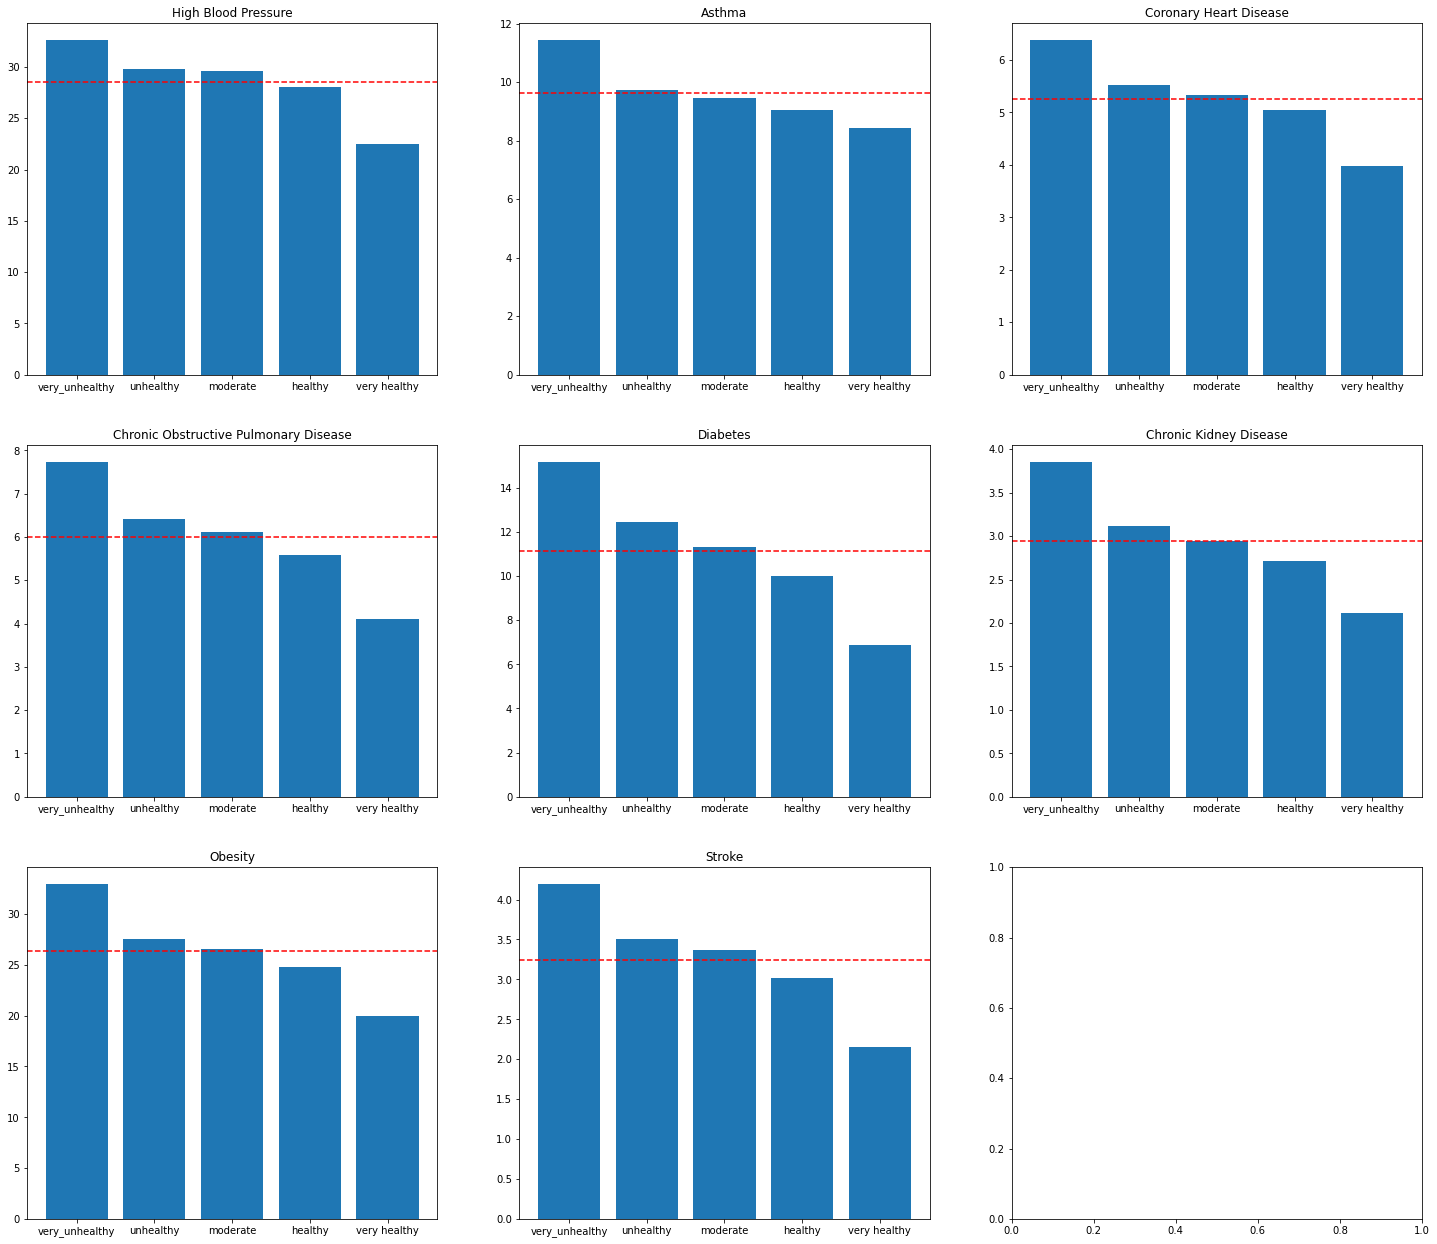

In [184]:
fig, ax = plt.subplots(3,3, figsize=(25,22))

labels = ['High Blood Pressure', 'Asthma', 'Coronary Heart Disease'
         , 'Chronic Obstructive Pulmonary Disease', 'Diabetes', 'Chronic Kidney Disease'
         , 'Obesity', 'Stroke']

for i,j in enumerate(['BPHIGH', 'CASTHMA', 'CHD'
                      , 'COPD', 'DIABETES', 'KIDNEY'
                      , 'OBESITY','STROKE']):
    
    ax[i//3][i%3].bar(x=HCI_Disease_G.index, height=HCI_Disease_G[j])
    ax[i//3][i%3].axhline(y=Disease[j].mean(), ls='--', color='r')
    label = labels[i]
    ax[i//3][i%3].set_title(label)

plt.show()

In [75]:
fig.savefig('./Image/Disease_Compare.jpg', dpi=600,bbox_inches='tight')

In [76]:
HCI_Disease

HCI        BE         E        NE        SE  BE_TreeD  \
36005000200 -1.018185 -1.239550 -0.423350 -0.674066 -0.989096 -0.662373   
36005000400  0.049467 -0.957275 -0.365252  0.173378  0.683893 -0.818237   
36005001600 -0.873549 -0.754709 -0.728937 -1.484363 -0.317841 -0.887313   
36005001900 -1.219488 -0.063740 -0.672512 -1.115435 -1.370066 -0.921100   
36005002000 -2.178403 -1.203926 -1.159506 -0.407992 -2.639204 -1.066606   
...               ...       ...       ...       ...       ...       ...   
36085030302 -0.176810 -1.260511 -0.145087 -0.643073  0.379613 -1.098438   
36085031901 -1.164781 -0.834547 -1.163321 -0.550746 -0.734644 -0.393352   
36085031902 -0.551519 -1.258539 -0.516565 -0.575895 -0.017740 -1.049660   
36085032300 -0.108753 -0.721600 -0.574839  1.011122  0.244841 -1.409038   
36005005300 -2.749315 -0.946686 -1.115162 -0.180545 -3.940366 -1.576767   

             BE_nodeD  BE_HFood  BE_WalkVSDrive  BE_Transit   BE_Park  \
36005000200 -0.396696 -0.842791       -0.903941   -0.740547 -0.045052   
36005000400 -0.531006 -0.842791       -1.036105   -0.781240 -0.391468   
36005001600  0.001192 -0.765981       -0.970307   -0.674569 -0.100558   
36005001900 -0.041036 -0.592375        0.906876    0.147751  1.381428   
36005002000 -0.469709 -0.790389       -1.127281   -0.716906 -0.142972   
...               ...       ...             ...         ...       ...   
36085030302 -1.163629 -0.701163       -1.235869   -0.839975 -0.703081   
36085031901 -1.163629 -0.577283        0.015960   -0.839975 -0.282025   
36085031902 -1.163629 -0.778929       -0.901001   -0.839975 -0.229482   
36085032300 -1.163629 -0.545574        0.928247   -0.839975  0.859943   
36005005300 -0.250737 -0.524504       -1.492913   -0.307073 -0.035103   

             BE_LandUseMix  BE_BikeD  E_Advance    E_PreS    NE_Tem  NE_Ozone  \
36005000200      -1.730821 -0.549264  -0.283513 -1.147894 -0.015916 -0.901082   
36005000400      -0.290617  0.113004  -0.332932 -0.342632  1.127930 -1.022041   
36005001600       0.018036 -0.301096  -0.822187  0.473043 -0.951260 -1.022411   
36005001900       0.134369  0.283459  -0.520727 -1.307558 -0.998114 -0.029927   
36005002000      -1.021263 -0.588386  -1.321325  0.851378  0.368881 -0.878936   
...                    ...       ...        ...       ...       ...       ...   
36085030302      -0.343824 -0.709268  -0.248919  0.719481 -0.909948  0.148765   
36085031901      -0.541223 -0.197802  -0.911142 -2.185710 -0.764333  0.161705   
36085031902      -0.693652 -0.709268  -0.392236 -1.061120 -0.784145  0.182526   
36085032300      -0.043004 -0.398305  -0.772767  1.285247  1.316352  0.109625   
36005005300      -0.688796  0.803734  -1.227428  0.500811  1.058516 -0.976103   

              NE_PM25  SE_Unemploy  SE_Insurance  SE_Poverty  SE_English  \
36005000200 -0.307798    -1.637542      0.176725   -0.684679    0.197051   
36005000400 -0.191383     0.070595      0.497105    0.775590    0.531820   
36005001600 -0.340169     0.398182      0.236796   -0.904196    0.058777   
36005001900 -1.007231    -0.982366     -1.445200   -1.390952    0.509987   
36005002000 -0.449710    -2.901095     -0.283822   -2.536261    0.349880   
...               ...          ...           ...         ...         ...   
36085030302 -0.097984     0.234388      0.497105    0.078860    0.728314   
36085031901 -0.186525     0.140792      0.757414   -1.810899    0.677371   
36085031902 -0.257438     1.029959      0.497105   -1.171435    0.822923   
36085032300 -0.237536     0.772568      0.637271   -0.570148    0.757425   
36005005300 -1.213646    -4.773025      0.216772   -3.672025    0.495432   

                   MH        PH       HCI_Class  ARTHRITIS  BPHIGH  CANCER  \
36005000200  0.002955 -0.226785  very_unhealthy       18.0    30.3     4.9   
36005000400  0.528212  0.532441        moderate       15.6    26.8     4.5   
36005001600 -0.732407 -1.219620  very_unhealthy       22.2    35.8     5.7   
36005001900 -0.942510 -0.372790  very_unhe

# Plot HCI

In [185]:
# geo data
ct2010 = gpd.read_file('./Data/Processed_Data/ct2010_geoid.geojson')
ct2010.head()

boro_code boro_ct201      boro_name cdeligibil  ct2010 ctlabel ntacode  \
0         5    5000900  Staten Island          E  000900       9    SI22   
1         1    1009800      Manhattan          I  009800      98    MN19   
2         1    1010200      Manhattan          I  010200     102    MN17   
3         1    1010400      Manhattan          I  010400     104    MN17   
4         1    1011300      Manhattan          I  011300     113    MN17   

                                     ntaname  puma    shape_area   shape_leng  \
0  West New Brighton-New Brighton-St. George  3903  2.497010e+06  7729.016794   
1                    Turtle Bay-East Midtown  3808  1.906016e+06  5534.200308   
2                      Midtown-Midtown South  3807  1.860993e+06  5687.802439   
3                      Midtown-Midtown South  3807  1.864600e+06  5693.036367   
4                      Midtown-Midtown South  3807  1.890907e+06  5699.860640   

         GeoID                                           geometry  
0  36085000900  POLYGON ((-74.07921 40.64343, -74.07914 40.643...  
1  36061009800  POLYGON ((-73.96433 40.75638, -73.96479 40.755...  
2  36061010200  POLYGON ((-73.97124 40.76094, -73.97170 40.760...  
3  36061010400  POLYGON ((-73.97446 40.76229, -73.97491 40.761...  
4  36061011300  POLYGON ((-73.98412 40.75484, -73.98460 40.754...

In [186]:
HCI_Geo = HCI.merge(ct2010, left_index=True, right_on='GeoID')
HCI_Geo = gpd.GeoDataFrame(HCI_Geo, geometry=HCI_Geo.geometry, crs=4326)
len(HCI_Geo)

2003

In [187]:
HCI_Geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [188]:
HCI_Geo[HCI_Geo.HCI_Class.isnull()]

Empty GeoDataFrame
Columns: [HCI, NB, TP, E, NE, SE, BE_TreeD, BE_HFood, BE_Park, BE_LandUseMix, BE_WalkVSDrive, BE_nodeD, BE_Transit, BE_BikeD, E_Advance, E_PreS, NE_Tem, NE_Ozone, NE_PM25, SE_Unemploy, SE_Insurance, SE_Poverty, SE_English, MH, PH, HCI_Class, boro_code, boro_ct201, boro_name, cdeligibil, ct2010, ctlabel, ntacode, ntaname, puma, shape_area, shape_leng, GeoID, geometry]
Index: []

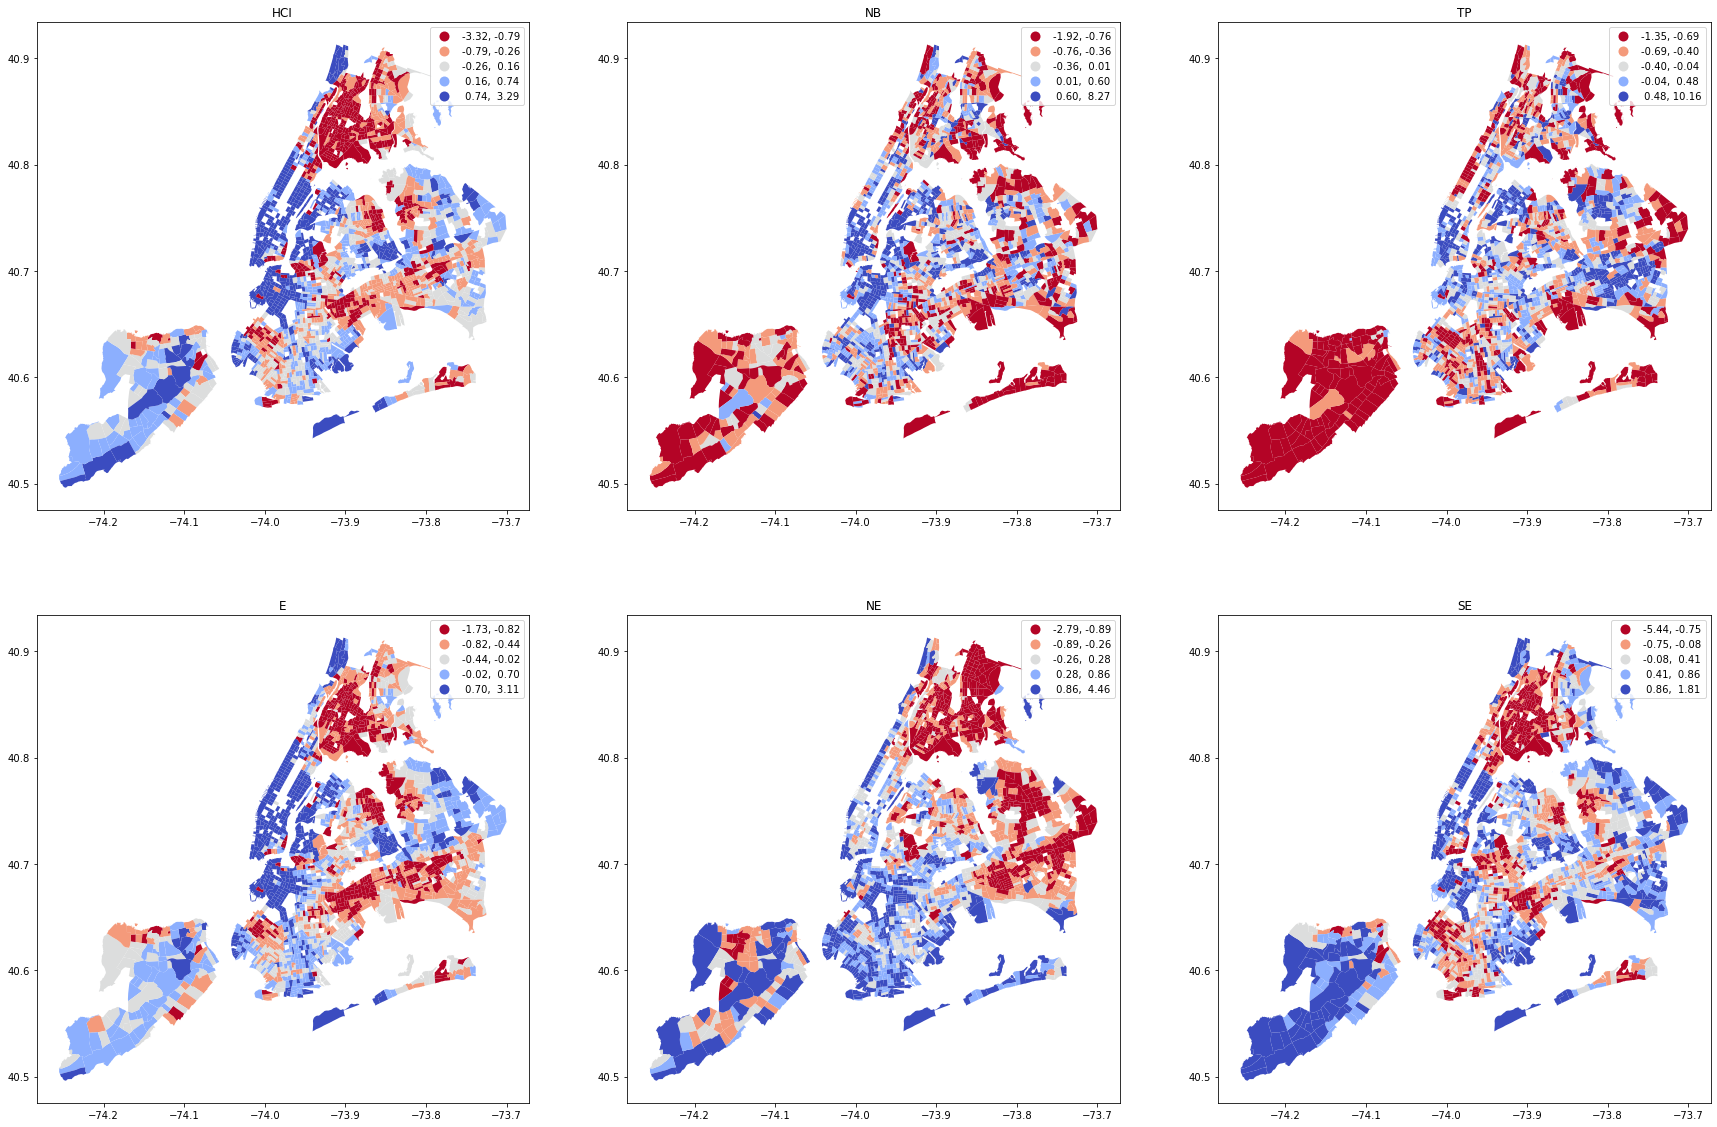

In [190]:
fig, ax = plt.subplots(2,3, figsize=(30,20))

a = ['HCI', 'NB', 'TP', 'E', 'NE', 'SE']

for i,j in enumerate(a):
    HCI_Geo.plot(column=j, cmap='coolwarm_r', ax=ax[i//3][i%3],
                              legend=True, scheme='Quantiles', k=5
                              #,figsize=(10,10)
                )
    
    label = j
    ax[i//3][i%3].set_title(label)
    
plt.show()

In [191]:
fig.savefig('./Image/HCI_Plot1.jpg', dpi=600,bbox_inches='tight')

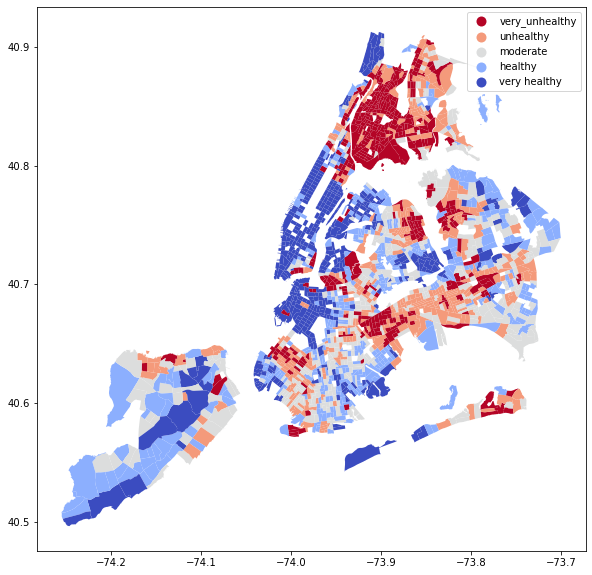

In [192]:
HCI_Geo.plot(column='HCI_Class', cmap='coolwarm_r'
                          ,legend=True
                          ,figsize=(10,10))


plt.show()

<img src="HCI_1.jpg" width="500">
<img src="Covid_19.jpg" width="500">

In [84]:
# Bottom Five
HCI_Geo.sort_values(by='HCI')[['HCI','boro_name','ntaname']].head(5)

HCI boro_name                                           ntaname
507  -3.447343  Brooklyn                                       Brownsville
2124 -3.042683  Brooklyn  DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill
2134 -2.941221  Brooklyn                                       Brownsville
2098 -2.816635  Brooklyn          Carroll Gardens-Columbia Street-Red Hook
1354 -2.749315     Bronx                 University Heights-Morris Heights

In [85]:
# Top Five
HCI_Geo.sort_values(by='HCI', ascending=False)[['HCI','BE','boro_name','ntaname']].head(5)

HCI        BE  boro_name                                 ntaname
1130  2.579702  0.125349  Manhattan       Battery Park City-Lower Manhattan
1475  2.571719  4.991212   Brooklyn                   North Side-South Side
832   2.566698  5.632113  Manhattan                   Midtown-Midtown South
1103  2.560211  0.615573  Manhattan  SoHo-TriBeCa-Civic Center-Little Italy
1129  2.549268  0.472008  Manhattan       Battery Park City-Lower Manhattan

In [86]:
HCI_Geo.sort_values(by=['HCI','BE'], ascending=True)[['HCI','BE','boro_name','ntaname']].head(5)

HCI        BE boro_name  \
507  -3.447343 -0.058413  Brooklyn   
2124 -3.042683 -0.345613  Brooklyn   
2134 -2.941221 -0.973985  Brooklyn   
2098 -2.816635 -1.298258  Brooklyn   
1354 -2.749315 -0.946686     Bronx   

                                               ntaname  
507                                        Brownsville  
2124  DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill  
2134                                       Brownsville  
2098          Carroll Gardens-Columbia Street-Red Hook  
1354                 University Heights-Morris Heights

In [87]:
HCI_Geo.sort_values(by=['BE'], ascending=True)[['HCI','BE','boro_name','ntaname']].head(5)

HCI        BE      boro_name  \
1922  0.547669 -1.578072  Staten Island   
1959 -0.399223 -1.547831          Bronx   
1836 -0.485197 -1.501782          Bronx   
775  -1.754769 -1.469561          Bronx   
2090  0.188059 -1.434367  Staten Island   

                                       ntaname  
1922                             Arden Heights  
1959                                Co-op City  
1836  Schuylerville-Throgs Neck-Edgewater Park  
775   Schuylerville-Throgs Neck-Edgewater Park  
2090                             Arden Heights